**Importation of Libraries**


In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.9 MB/s eta 0:00:00


In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import catboost as cb

**Loading of Inflation Dataset**

In [ ]:
# Load Data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load and Clean Inflation Data
# Load Inflation Data
inflation_df = pd.read_csv("/content/drive/MyDrive/Datasets_FYP/inflation_data.csv")

In [ ]:
# Rename Order Date
inflation_df.rename(columns={"Date": "Order_date"}, inplace=True)

In [ ]:
# Convert Order Date to datetime
inflation_df['Order_date'] = pd.to_datetime(inflation_df['Order_date'], format="%m/%d/%Y", errors='coerce')

# Create Year-Month Column
inflation_df['Year_Month'] = inflation_df['Order_date'].dt.to_period('M')

**Loading of Sales Data**

In [ ]:
# Load and Clean Sales Data (2021–2024)
sales_files = [
    "/content/drive/MyDrive/Datasets_FYP/sales_data_2021.csv",
    "/content/drive/MyDrive/Datasets_FYP/sales_data_2022.csv",
    "/content/drive/MyDrive/Datasets_FYP/sales_data_2023.csv",
    "/content/drive/MyDrive/Datasets_FYP/sales_data_2024.csv",
]

**Merging of Datasets**

In [ ]:
# Load and merge sales data
sales_df = pd.concat((pd.read_csv(file) for file in sales_files), ignore_index=True)

In [ ]:
# Convert 'Order_date' to datetime in sales_df
sales_df['Order_date'] = pd.to_datetime(sales_df['Order_date'], dayfirst=True, errors='coerce')

In [ ]:
# Creating Year-Month Column
sales_df['Year_Month'] = sales_df['Order_date'].dt.to_period('M')

**Loading of Weather Data**

In [ ]:
# Load and Clean Weather Data
weather_df = pd.read_csv("/content/drive/MyDrive/Datasets_FYP/weather_data .csv")

In [ ]:
# Rename 'Date' column in df_weather to 'Order_date' to ensure consistency
weather_df.rename(columns={'Date': 'Order_date'}, inplace=True)

In [ ]:
# Convert to Date-Time in df_weather
weather_df['Order_date'] = pd.to_datetime(weather_df['Order_date'], format="%m/%d/%Y", errors='coerce')

**Merging of Datasets**

In [ ]:
# Merge Sales & Weather on Order Date
sales_weather_df = pd.merge(sales_df, weather_df, on='Order_date', how='left')

In [ ]:
# Merge with Inflation Data (Monthly Matching)

final_merged_df = pd.merge(
    sales_weather_df,
    inflation_df[['Year_Month', 'Inflation_index_2021', 'YoY_inflation_rate']],
    on='Year_Month',
    how='left'
)

**Clean Up and Final Check**

In [ ]:
# Clean up
final_merged_df = final_merged_df.dropna(subset=['Order_date'])
final_merged_df['Inflation_index_2021'] = final_merged_df['Inflation_index_2021'].fillna(method='bfill')
final_merged_df['YoY_inflation_rate'] = final_merged_df['YoY_inflation_rate'].fillna(method='bfill')

<ipython-input-17-5f31542f82d5>:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  final_merged_df['Inflation_index_2021'] = final_merged_df['Inflation_index_2021'].fillna(method='bfill')
<ipython-input-17-5f31542f82d5>:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  final_merged_df['YoY_inflation_rate'] = final_merged_df['YoY_inflation_rate'].fillna(method='bfill')


In [ ]:
# Round YoY inflation to 2 decimal places
final_merged_df['YoY_inflation_rate'] = final_merged_df['YoY_inflation_rate'].round(2)


In [ ]:
# Final Check

print("Head of Final Merged Dataset:")
display(final_merged_df.head())

print("Missing Values Summary:")
print(final_merged_df.isnull().sum())
print(final_merged_df[['Inflation_index_2021', 'YoY_inflation_rate']].isnull().sum())

Head of Final Merged Dataset:


,Order_ID,Workflow ID,Order_date,Order_confirmed_time,Dining_mode,Payment_Mode,Order_channel,Order_status,Customer_Uber_Membership_Status,Sales_excl_tax,...,apparent_temperature_max,apparent_temperature_min,sunrise,sunset,precipitation_sum,rain_sum,precipitation_hours,shortwave_radiation_sum,Inflation_index_2021,YoY_inflation_rate
0,#AF757,24d61b46-af8f-4050-a2c8-df726fcaf757,2021-01-01,19:19,Delivery – partner using Uber app,Unknown,Android,Completed,Data not available,1000,...,33.5,26.5,2021-01-01T06:22,2021-01-01T18:05,4.7,4.7,9,11.55,100.0,4.6
1,#2C745,34f4ed1f-8ad7-4ab1-b923-66c84ee2c745,2021-01-01,20:25,Delivery – partner using Uber app,Unknown,Android,Completed,Data not available,1550,...,33.5,26.5,2021-01-01T06:22,2021-01-01T18:05,4.7,4.7,9,11.55,100.0,4.6
2,#14A5F,0229227a-9cd6-4860-9b10-f141bab14a5f,2021-01-01,20:28,Delivery – partner using Uber app,Unknown,iOS,Completed,Data not available,600,...,33.5,26.5,2021-01-01T06:22,2021-01-01T18:05,4.7,4.7,9,11.55,100.0,4.6
3,#0295B,e8479436-1c39-4ee6-a376-f47d1310295b,2021-01-02,17:28,Delivery – partner using Uber app,Unknown,Android,Completed,Data not available,1000,...,33.7,25.7,2021-01-02T06:22,2021-01-02T18:06,1.5,1.5,7,14.02,100.0,4.6
4,#C0908,a28fc2b1-a30c-4d6f-8a73-55cda31c0908,2021-01-02,18:47,Delivery – partner using Uber app,Unknown,iOS,Completed,Data not available,3400,...,33.7,25.7,2021-01-02T06:22,2021-01-02T18:06,1.5,1.5,7,14.02,100.0,4.6


Missing Values Summary:
Order_ID                                   1240
Workflow ID                                1240
Order_date                                    0
Order_confirmed_time                       1240
Dining_mode                                1337
Payment_Mode                               1337
Order_channel                                 0
Order_status                               1240
Customer_Uber_Membership_Status            1240
Sales_excl_tax                                0
Tax_on_sales                                  0
Refunds_excl_tax                              0
Tax_on_refunds                                0
Price_adjustments_excl_tax                    0
Tax_on_price_adjustments                      0
Promotions_on_items_excl_tax                  0
Tax_on_promotion_on_items                     0
Promotions_on_items_incl_tax                  0
Delivery_charge_excl_tax                      0
Tax_on_delivery_fee                           0
Promotions_on_de

**Pre-Cleaning Exploratory Data Analysis (EDA)**

In [ ]:
# Check structure of the datasets
sales_df.info()
weather_df.info()
inflation_df.info()
final_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20839 entries, 0 to 20838
Data columns (total 45 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   Order_ID                                19599 non-null  object        
 1   Workflow ID                             19599 non-null  object        
 2   Order_date                              20839 non-null  datetime64[ns]
 3   Order_confirmed_time                    19599 non-null  object        
 4   Dining_mode                             19502 non-null  object        
 5   Payment_Mode                            19502 non-null  object        
 6   Order_channel                           20839 non-null  object        
 7   Order_status                            19599 non-null  object        
 8   Customer_Uber_Membership_Status         19599 non-null  object        
 9   Sales_excl_tax                          20839 non-

In [ ]:
print("Dataset Shape:", final_merged_df.shape)

Dataset Shape: (20839, 58)


In [ ]:
#First few rows check
display(final_merged_df.head())

,Order_ID,Workflow ID,Order_date,Order_confirmed_time,Dining_mode,Payment_Mode,Order_channel,Order_status,Customer_Uber_Membership_Status,Sales_excl_tax,...,apparent_temperature_max,apparent_temperature_min,sunrise,sunset,precipitation_sum,rain_sum,precipitation_hours,shortwave_radiation_sum,Inflation_index_2021,YoY_inflation_rate
0,#AF757,24d61b46-af8f-4050-a2c8-df726fcaf757,2021-01-01,19:19,Delivery – partner using Uber app,Unknown,Android,Completed,Data not available,1000,...,33.5,26.5,2021-01-01T06:22,2021-01-01T18:05,4.7,4.7,9,11.55,100.0,4.6
1,#2C745,34f4ed1f-8ad7-4ab1-b923-66c84ee2c745,2021-01-01,20:25,Delivery – partner using Uber app,Unknown,Android,Completed,Data not available,1550,...,33.5,26.5,2021-01-01T06:22,2021-01-01T18:05,4.7,4.7,9,11.55,100.0,4.6
2,#14A5F,0229227a-9cd6-4860-9b10-f141bab14a5f,2021-01-01,20:28,Delivery – partner using Uber app,Unknown,iOS,Completed,Data not available,600,...,33.5,26.5,2021-01-01T06:22,2021-01-01T18:05,4.7,4.7,9,11.55,100.0,4.6
3,#0295B,e8479436-1c39-4ee6-a376-f47d1310295b,2021-01-02,17:28,Delivery – partner using Uber app,Unknown,Android,Completed,Data not available,1000,...,33.7,25.7,2021-01-02T06:22,2021-01-02T18:06,1.5,1.5,7,14.02,100.0,4.6
4,#C0908,a28fc2b1-a30c-4d6f-8a73-55cda31c0908,2021-01-02,18:47,Delivery – partner using Uber app,Unknown,iOS,Completed,Data not available,3400,...,33.7,25.7,2021-01-02T06:22,2021-01-02T18:06,1.5,1.5,7,14.02,100.0,4.6


In [ ]:
# Count missing values
final_merged_df.isnull().sum().sort_values(ascending=False)

,0
Invoice_link_U2R,20839
Invoice_link_R2E,20839
Retailer_Loyalty_ID,20839
Invoice_link_C2R,20839
Other_payments_description,19599
Dining_mode,1337
Payment_Mode,1337
Workflow ID,1240
Order_confirmed_time,1240
Order_ID,1240


In [ ]:
# Identify duplicate rows
final_merged_df.duplicated().sum()

np.int64(1)

In [ ]:
# Check for duplicate rows in your final merged DataFrame
duplicate_rows = final_merged_df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

Number of duplicate rows: 1


In [ ]:
# Remove the duplicate row (keeping the first occurrence)
final_merged_df.drop_duplicates(keep='first', inplace=True)

In [ ]:
# Confirm removal
remaining_duplicates = final_merged_df.duplicated().sum()
print(f"Number of duplicate rows after removal: {remaining_duplicates}")

Number of duplicate rows after removal: 0


In [ ]:
# Date Range sanity check
# Minimum and maximum dates
print(final_merged_df['Order_date'].min(), final_merged_df['Order_date'].max())

2021-01-01 00:00:00 2024-12-31 00:00:00


In [ ]:
# Cardinality - for encoding strategy
for col in ['Order_channel', 'Dining_mode', 'Payment_Mode']:
    print(f"{col}: {final_merged_df[col].nunique()} unique values")

Order_channel: 4 unique values
Dining_mode: 1 unique values
Payment_Mode: 1 unique values


<Axes: ylabel='Frequency'>

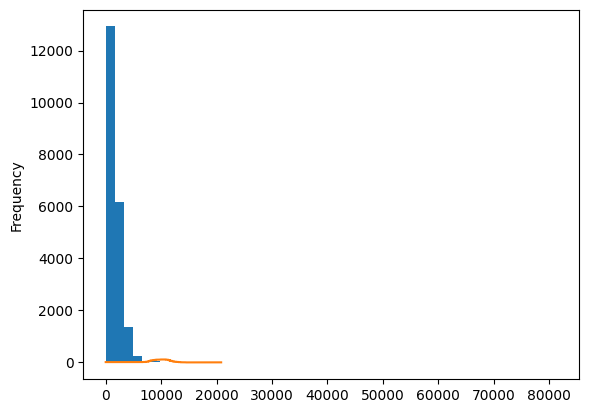

In [ ]:
# Quick visual inspection of skew, distribution, and possible anomalies.
final_merged_df['Sales_excl_tax'].plot(kind='hist', bins=50)
final_merged_df['YoY_inflation_rate'].plot(kind='line')

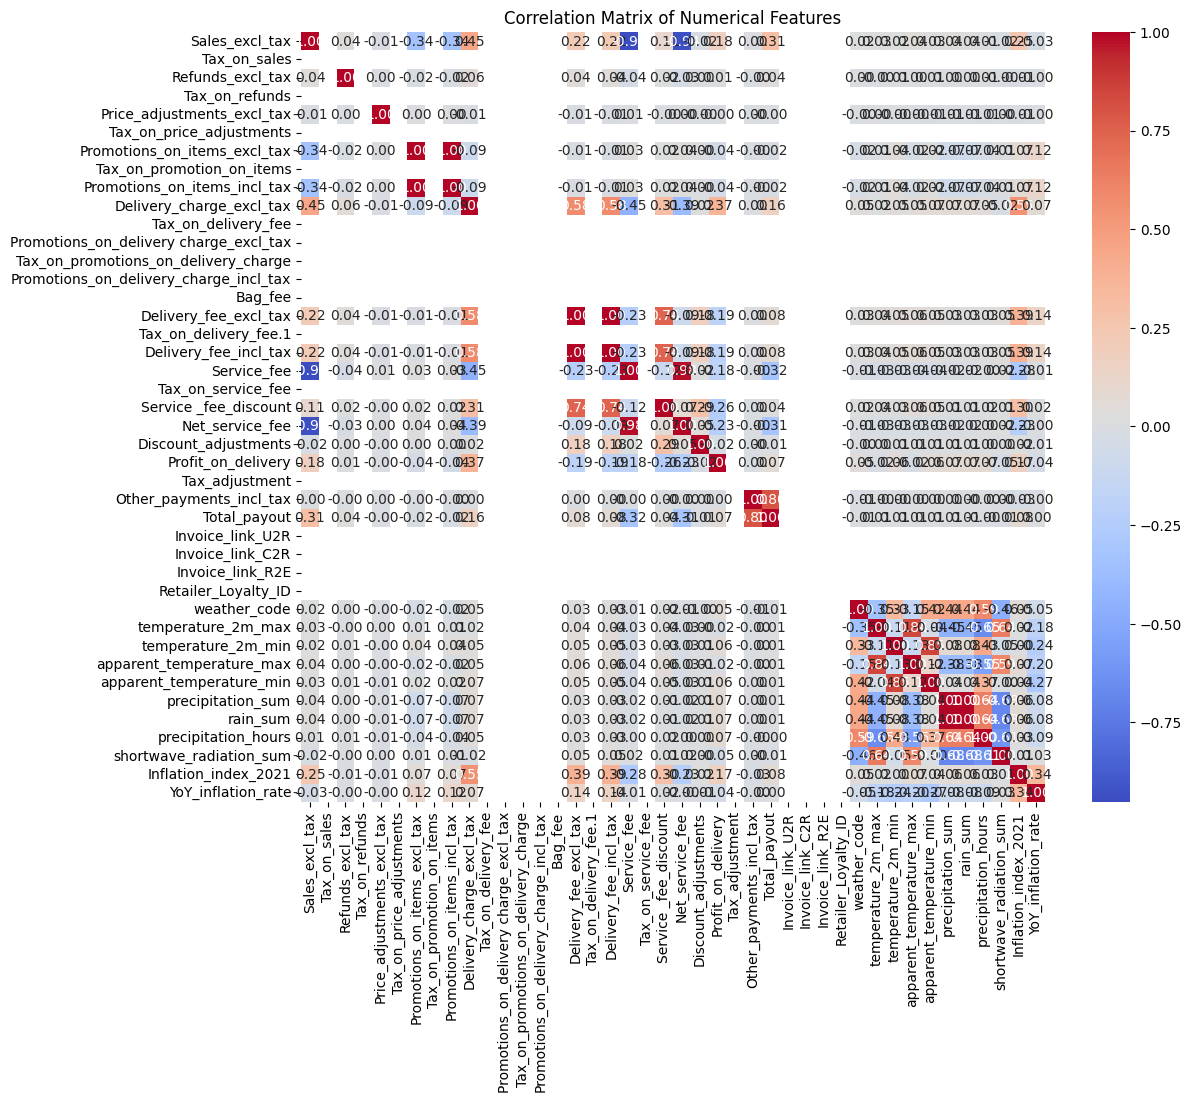

In [ ]:
# Correlation Heatmap
plt.figure(figsize=(12, 10))
# Ensure to use the DataFrame containing the features you want to analyze
correlation_matrix = final_merged_df.select_dtypes(include=np.number).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [ ]:
# Statistical Summary
print(final_merged_df.describe())

                          Order_date  Sales_excl_tax  Tax_on_sales  \
count                          20838    20838.000000       20838.0   
mean   2022-12-17 14:06:35.968902656     1652.419138           0.0   
min              2021-01-01 00:00:00        0.000000           0.0   
25%              2021-10-17 00:00:00     1050.000000           0.0   
50%              2022-12-24 00:00:00     1400.000000           0.0   
75%              2024-02-09 00:00:00     1990.000000           0.0   
max              2024-12-31 00:00:00    81375.000000           0.0   
std                              NaN     1253.706459           0.0   

       Refunds_excl_tax  Tax_on_refunds  Price_adjustments_excl_tax  \
count      20838.000000         20838.0                20838.000000   
mean          -1.963425             0.0                    0.000960   
min        -2350.000000             0.0                    0.000000   
25%            0.000000             0.0                    0.000000   
50%           

In [ ]:
# Identify numeric and categorical columns
numeric_cols = final_merged_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = final_merged_df.select_dtypes(include=['object', 'category']).columns.tolist()

<ipython-input-34-fe39f22eb7a0>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 6))


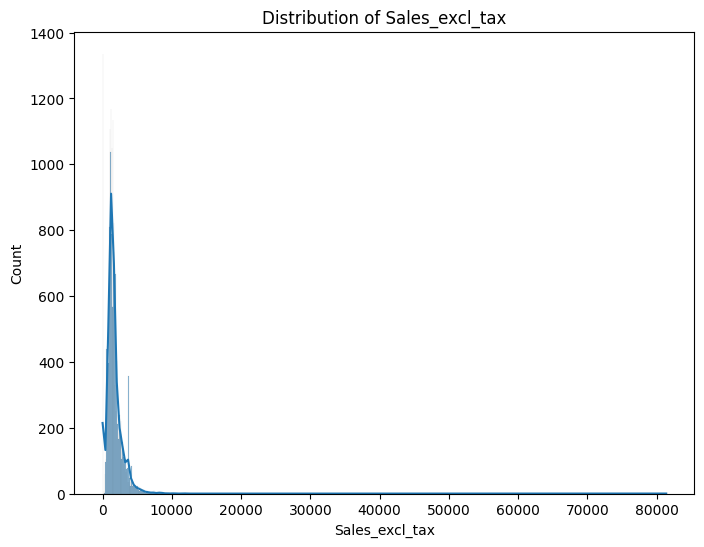

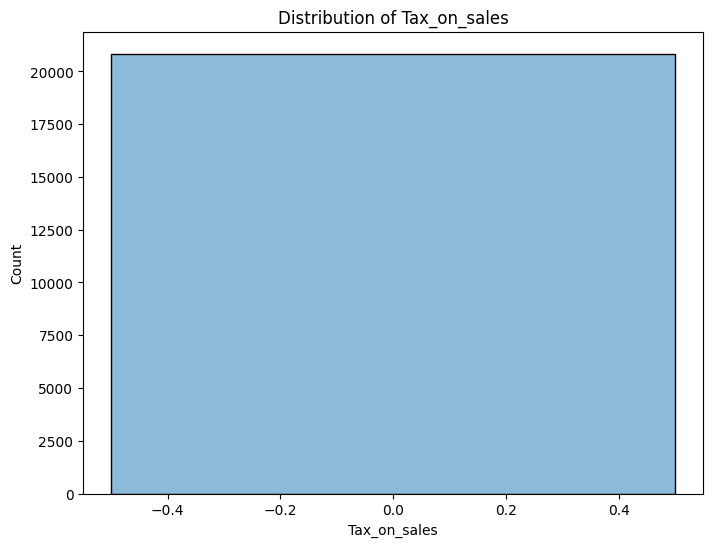

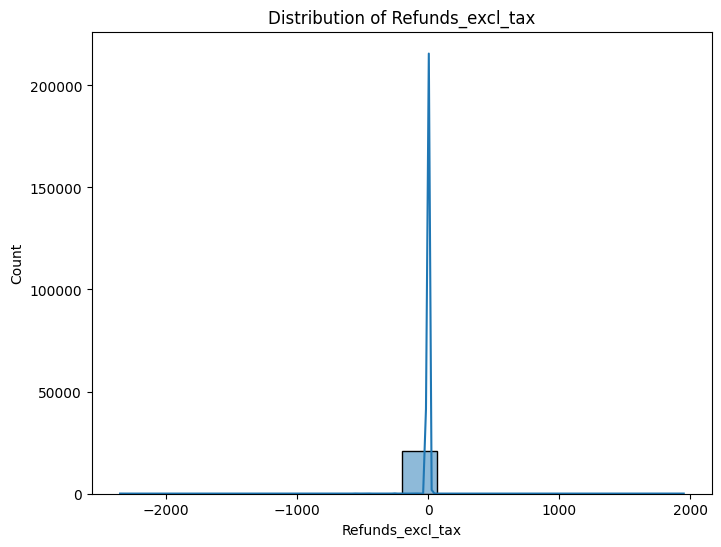

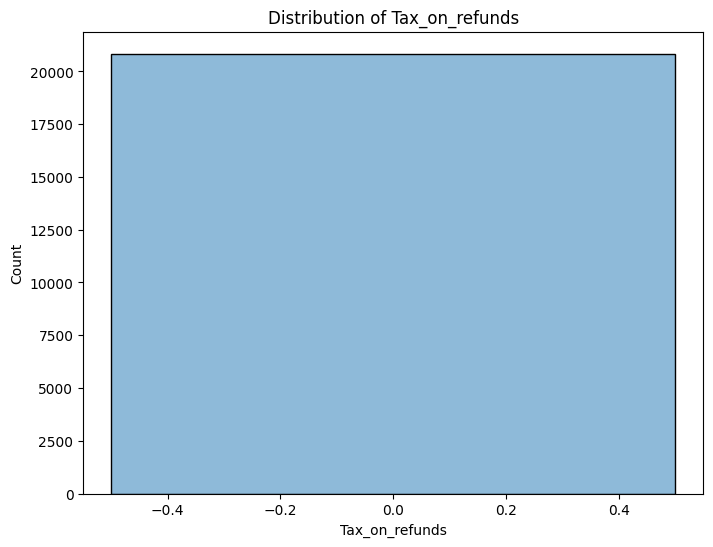

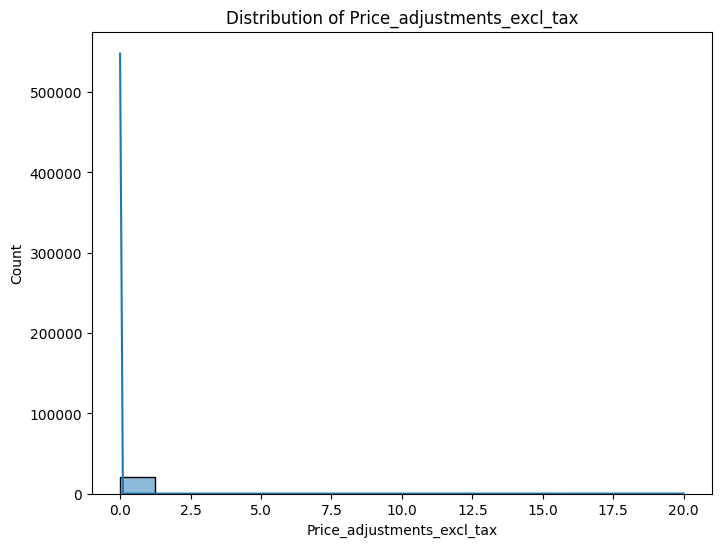

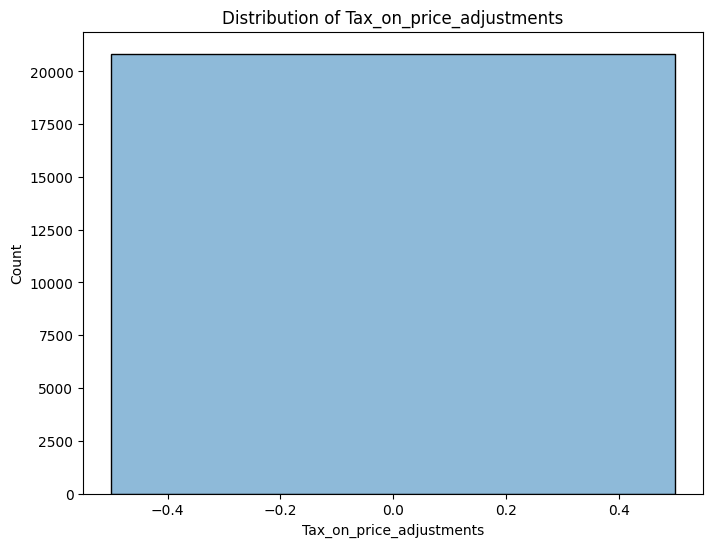

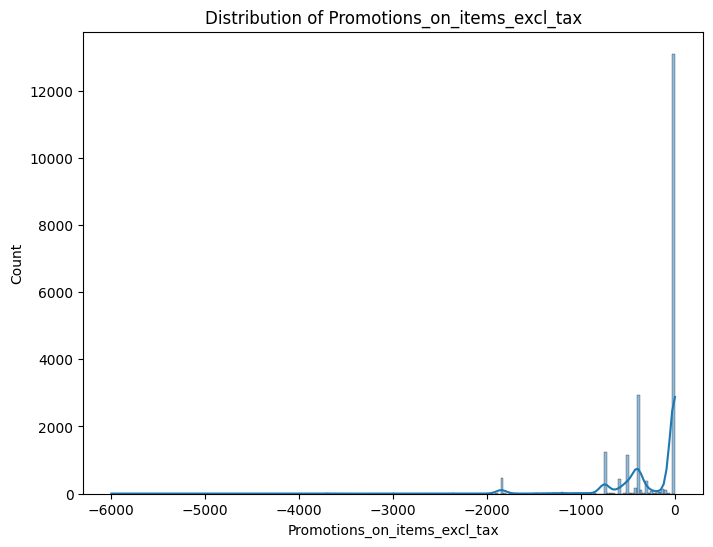

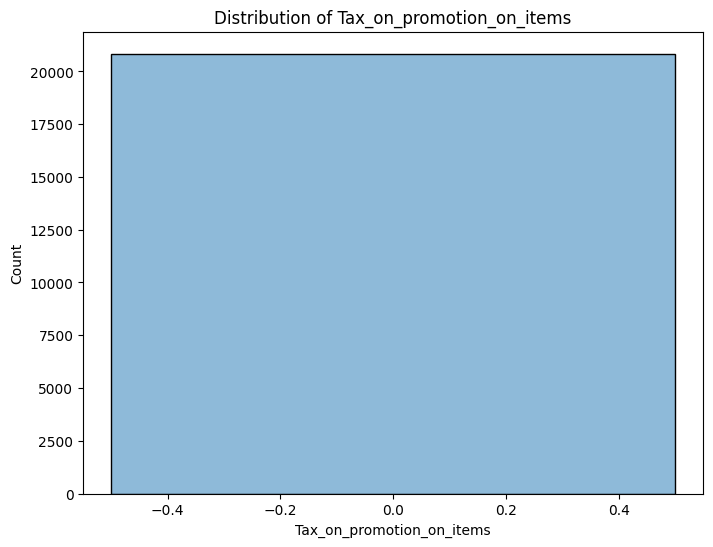

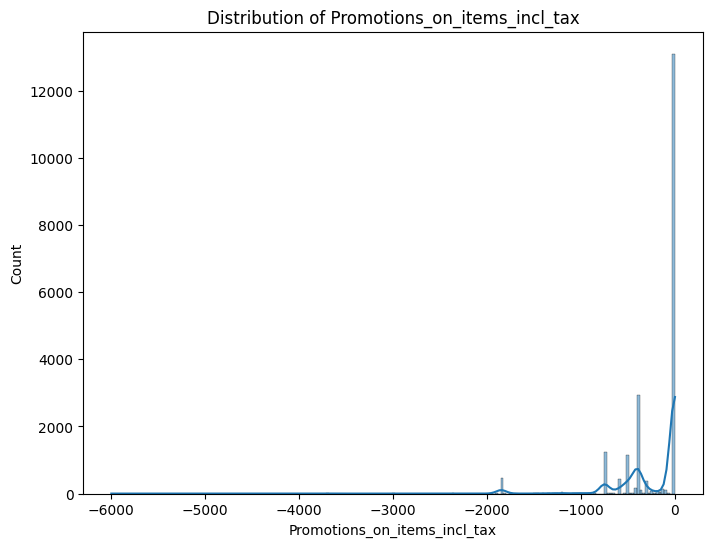

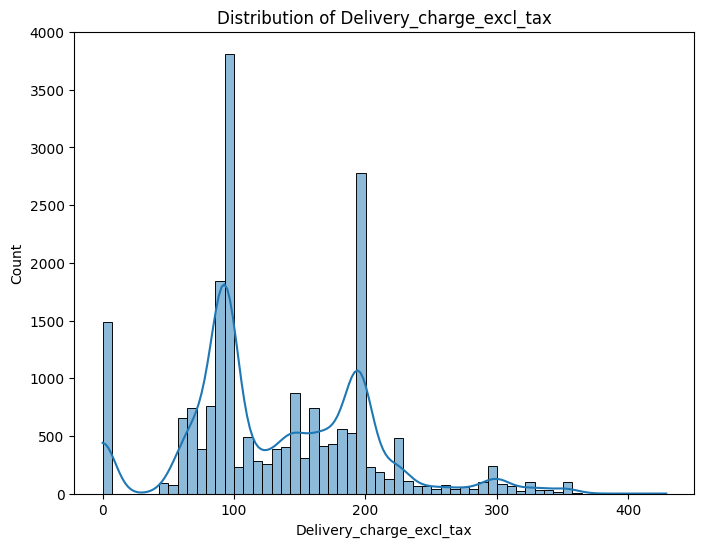

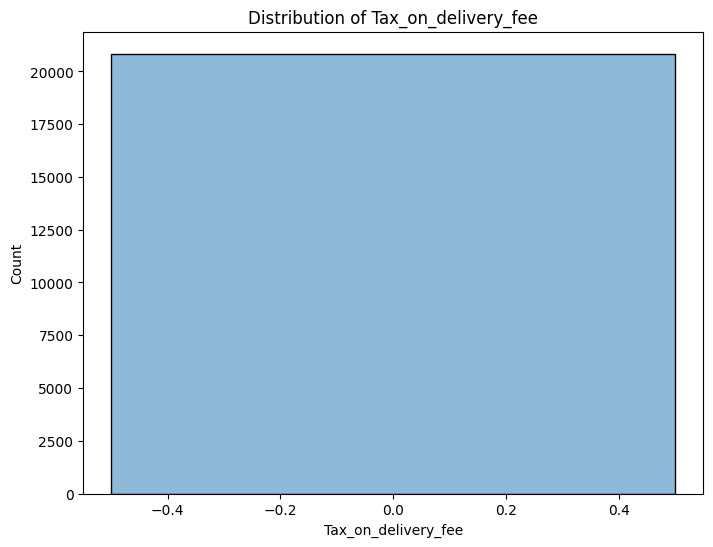

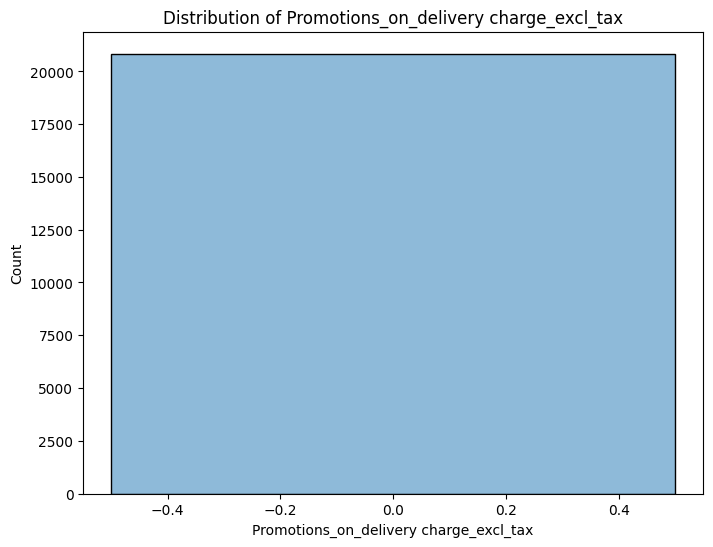

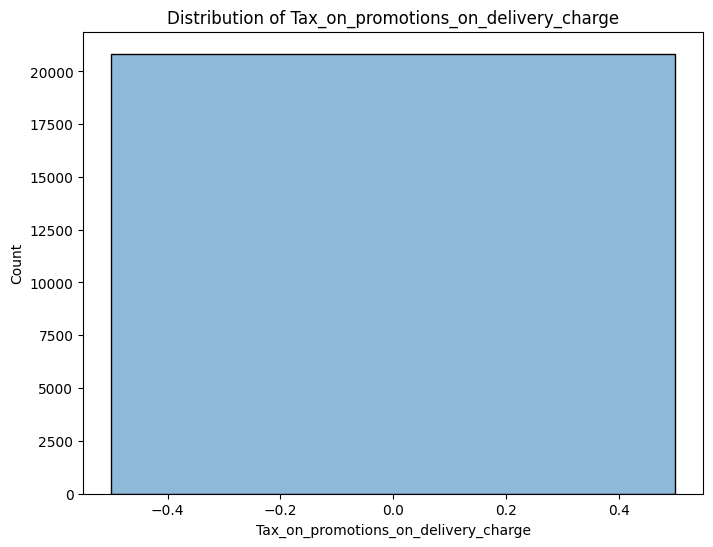

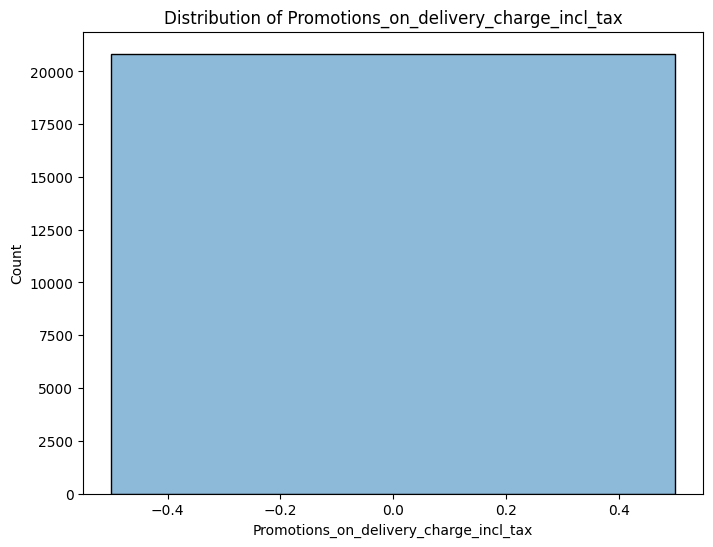

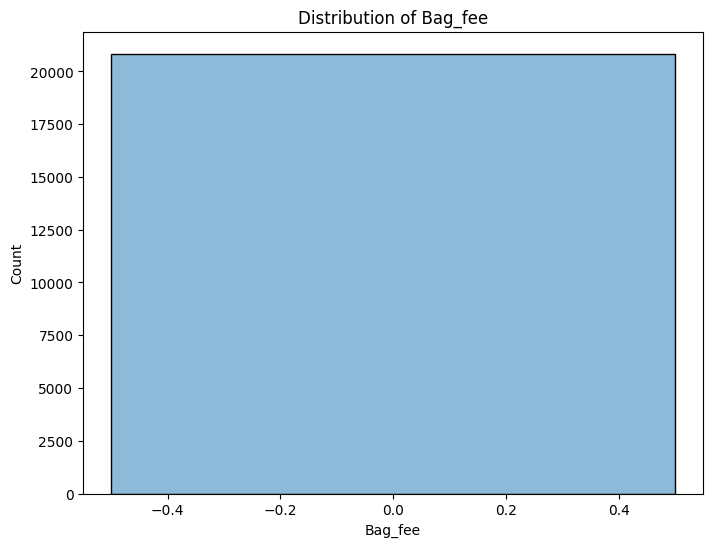

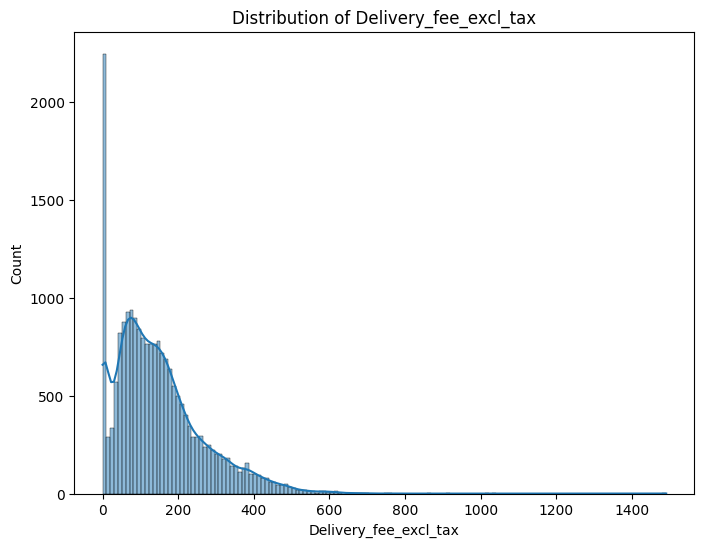

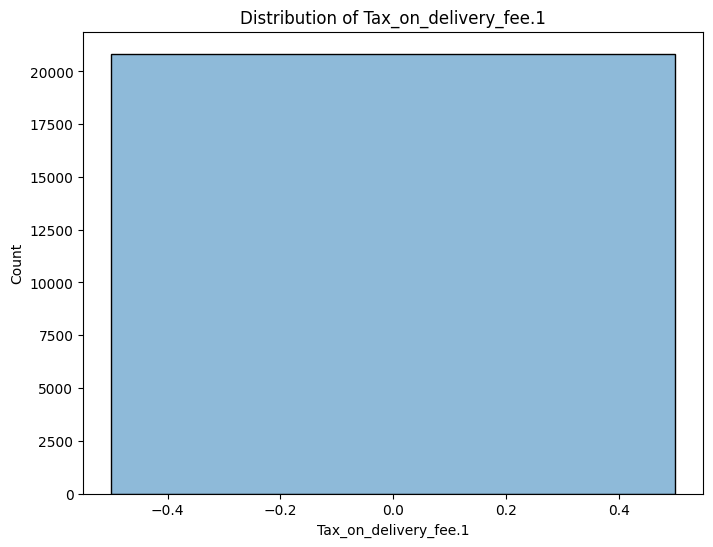

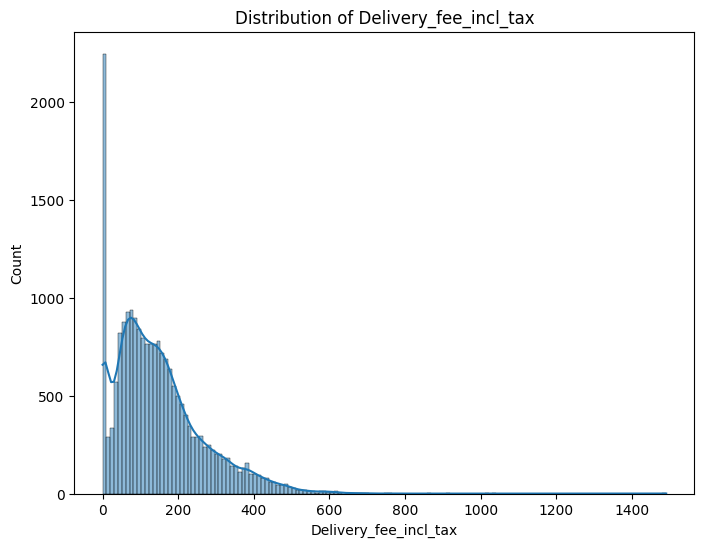

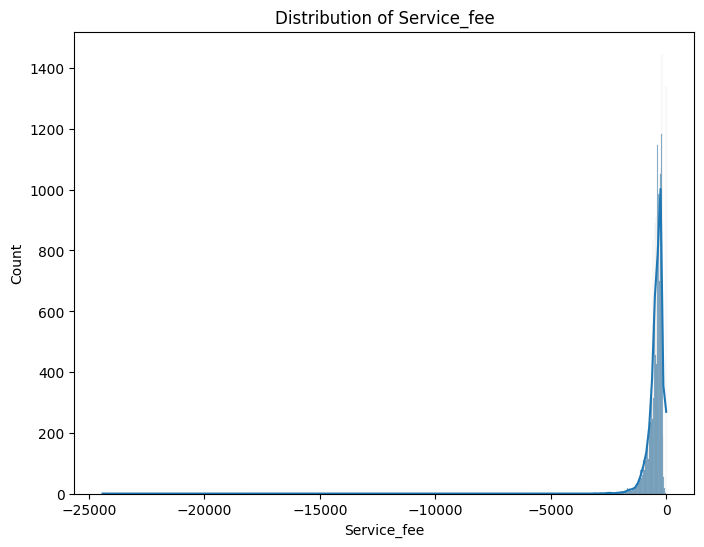

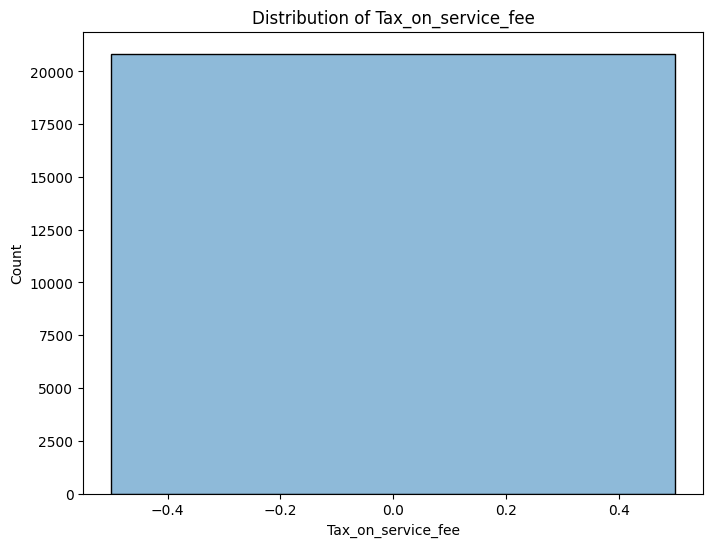

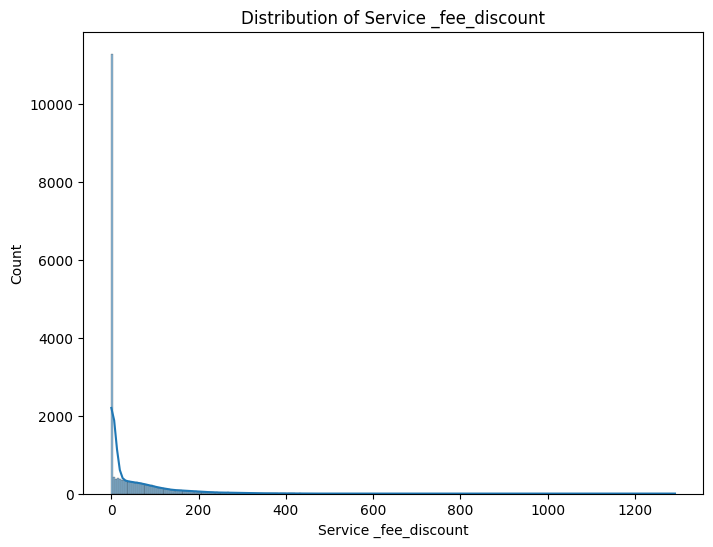

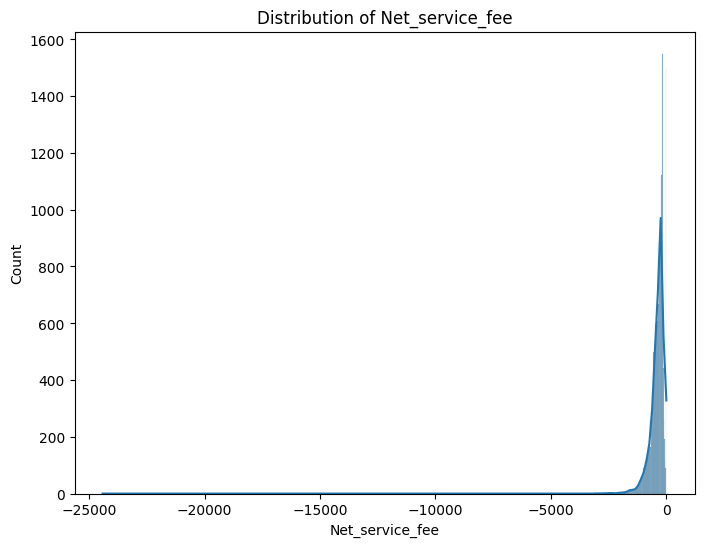

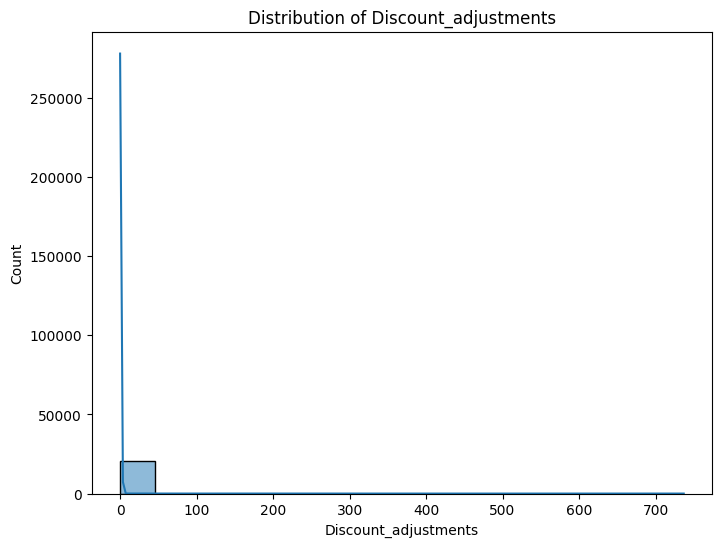

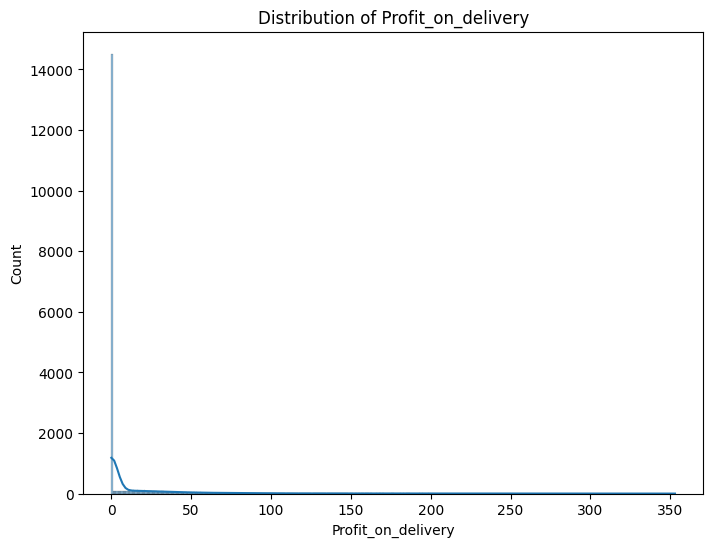

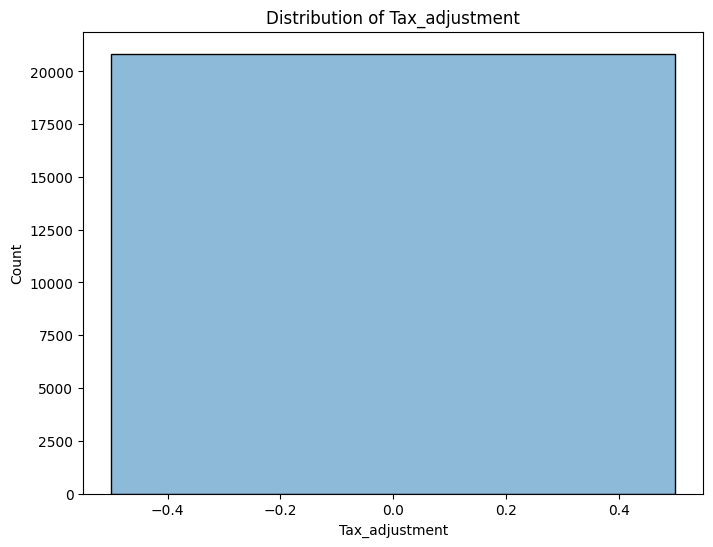

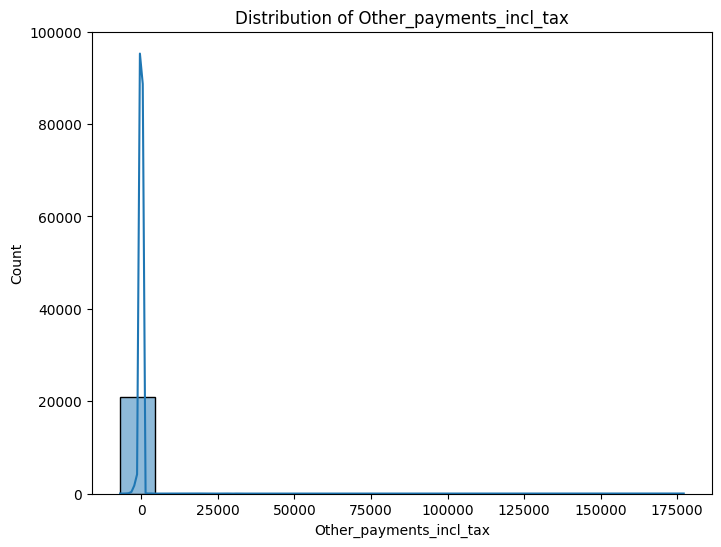

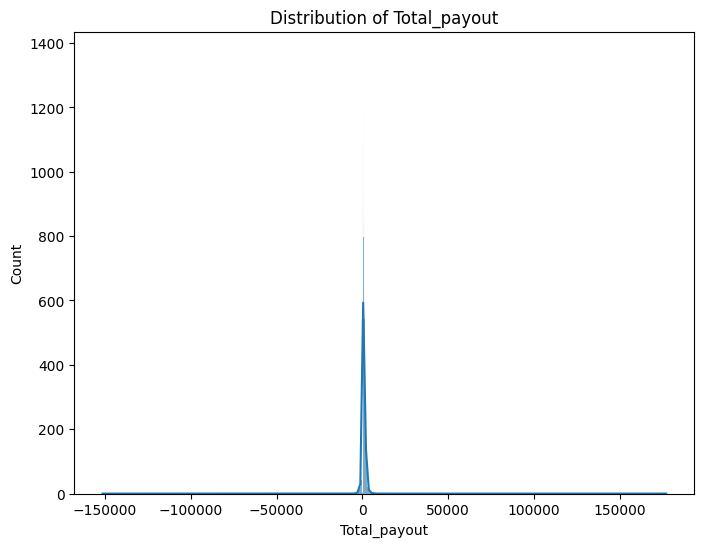

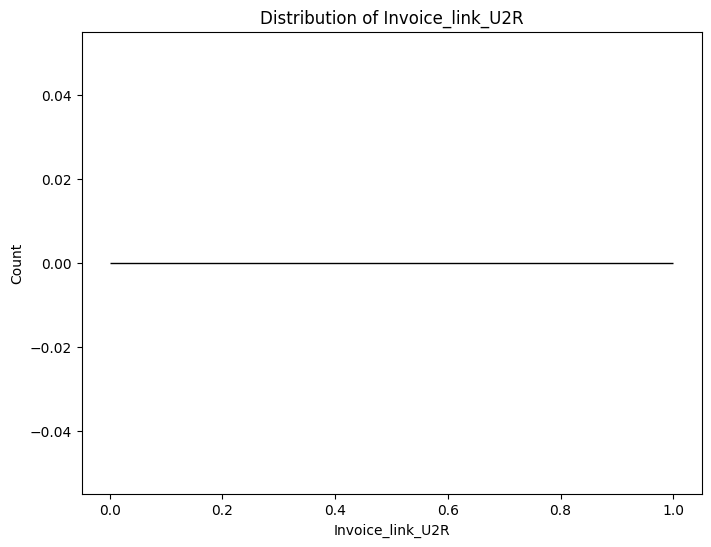

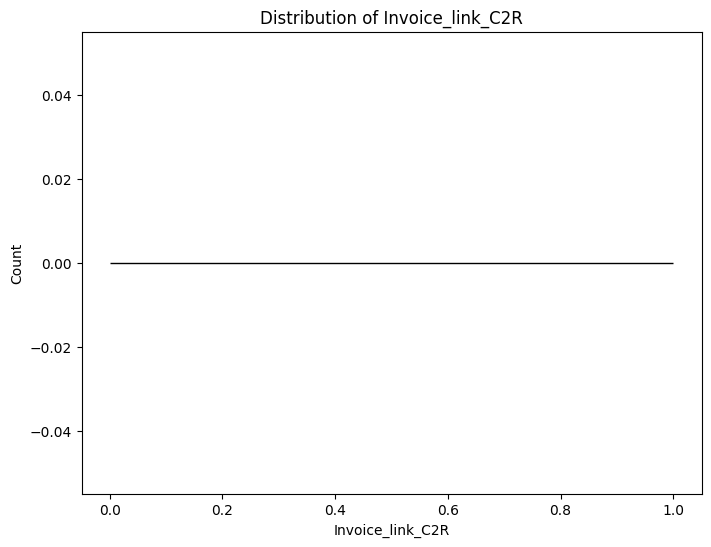

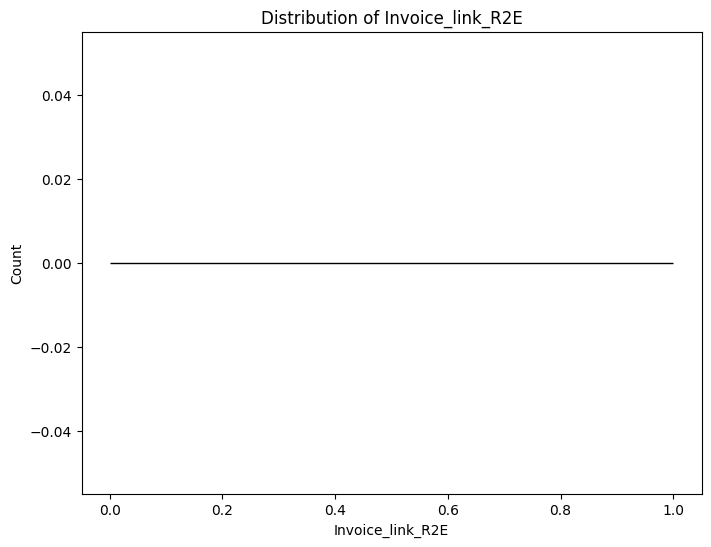

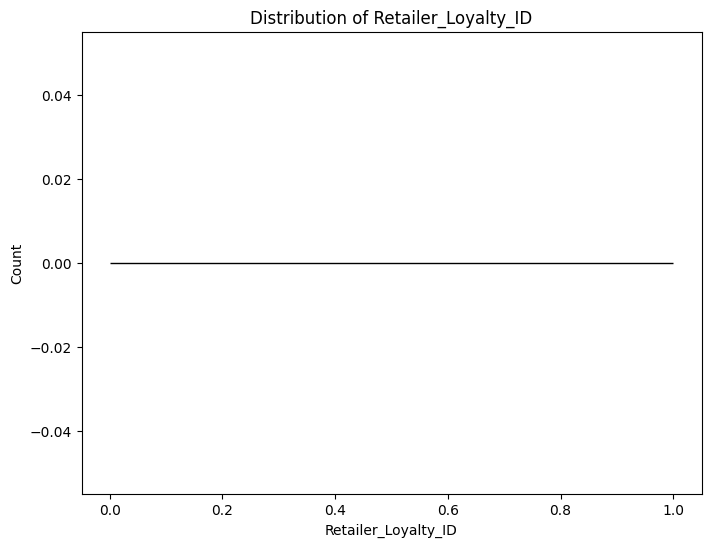

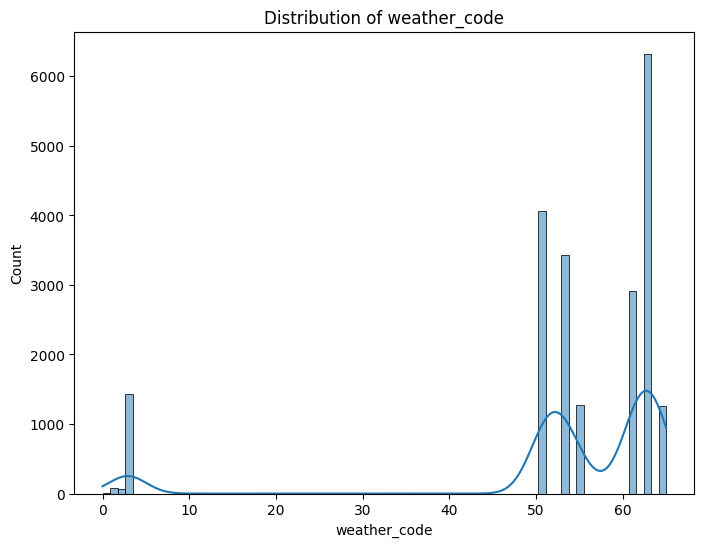

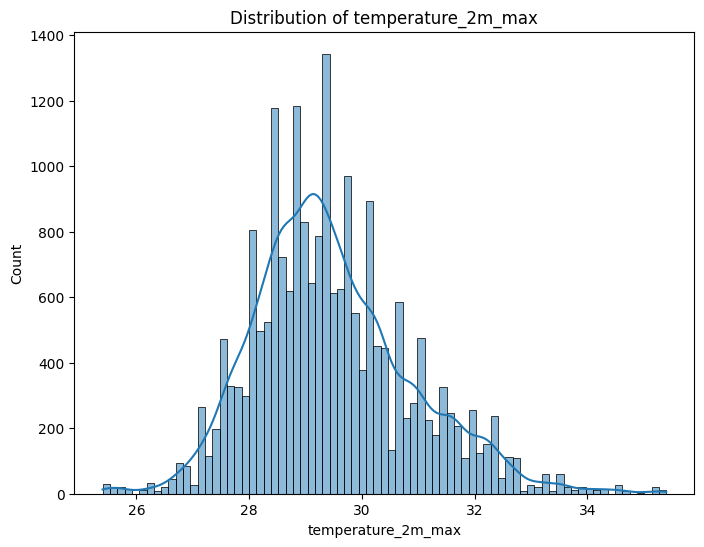

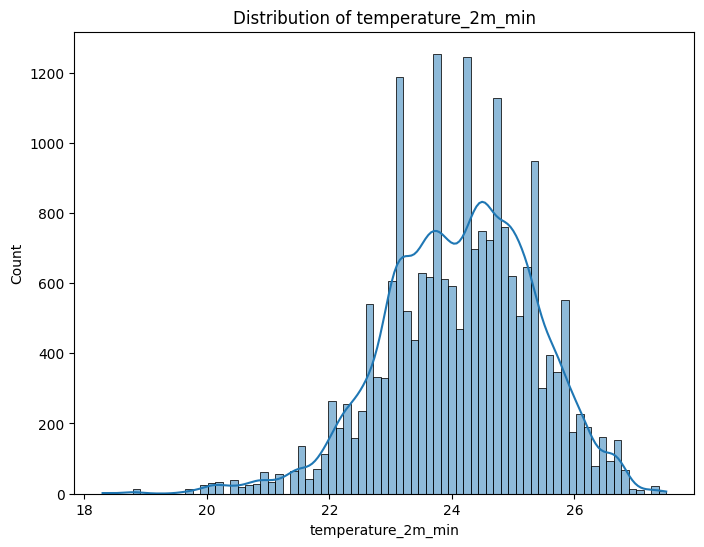

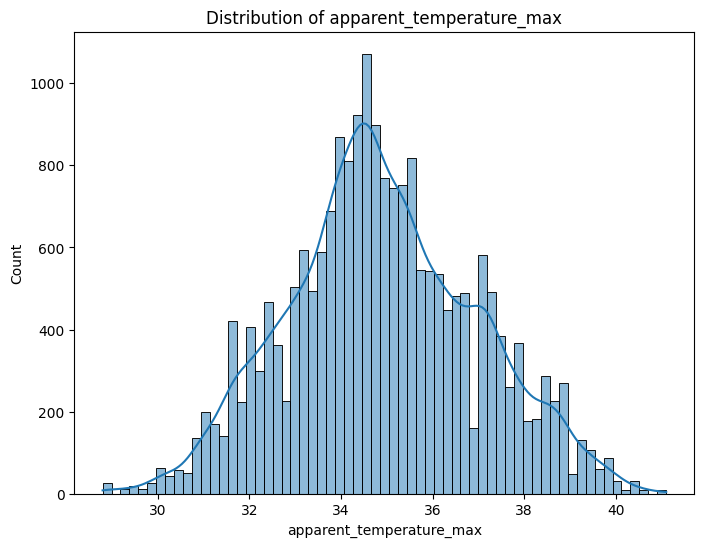

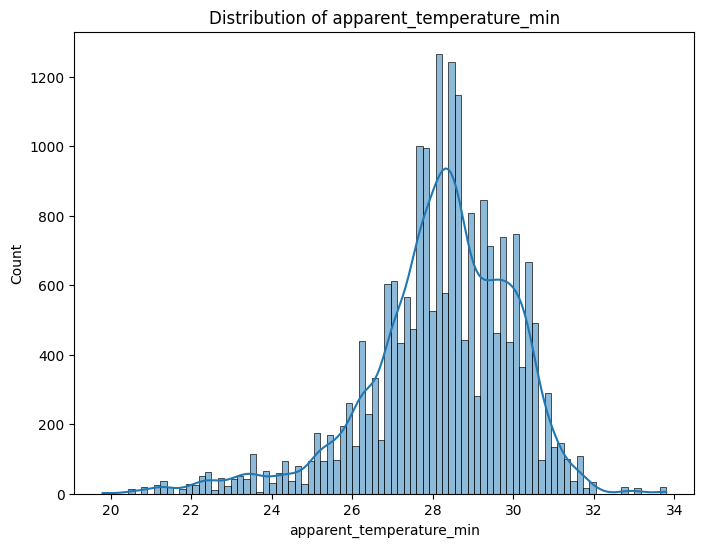

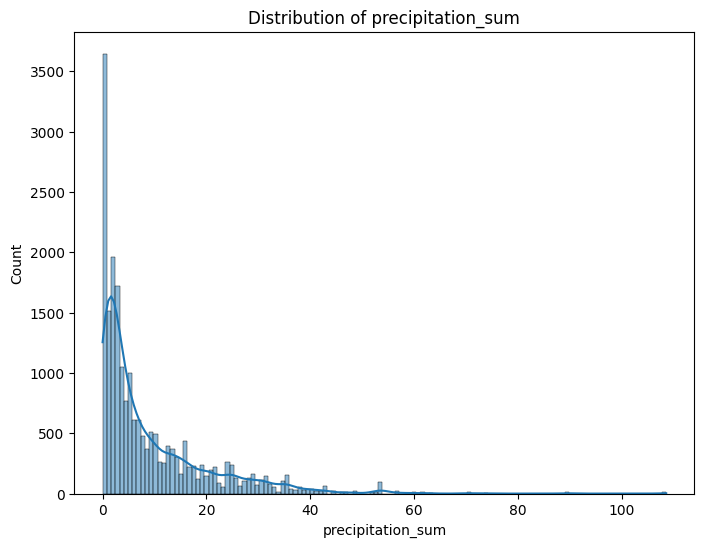

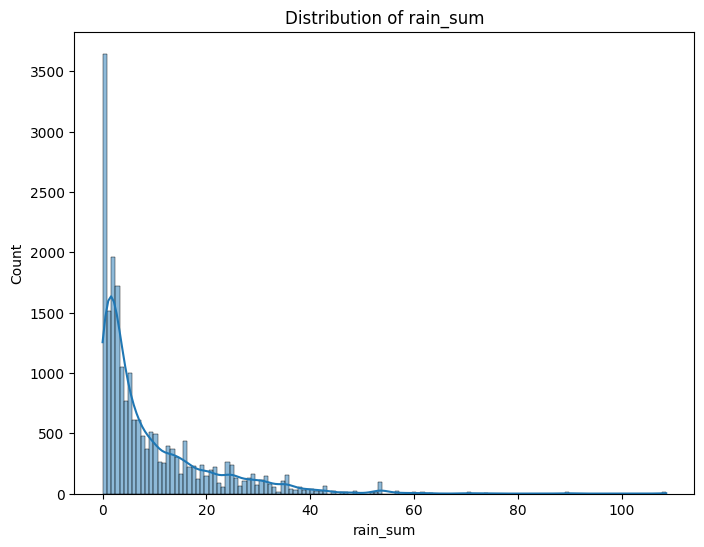

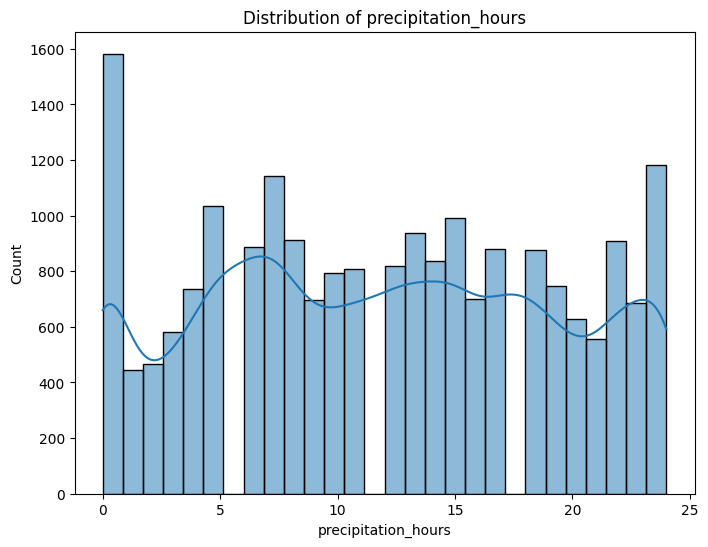

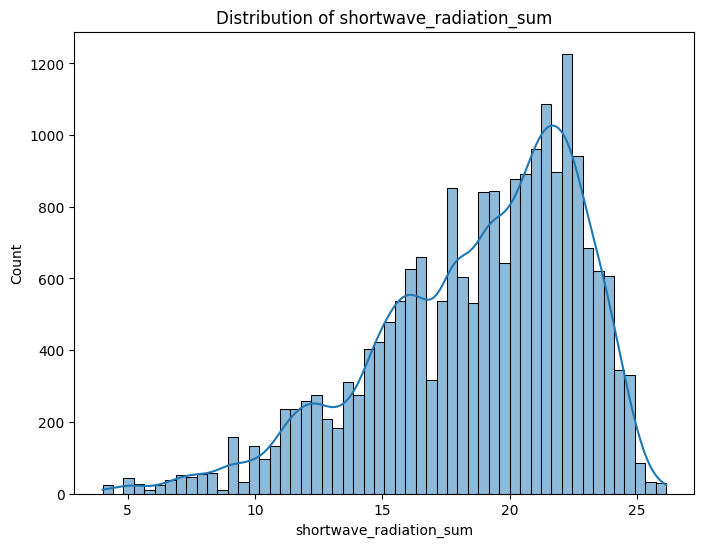

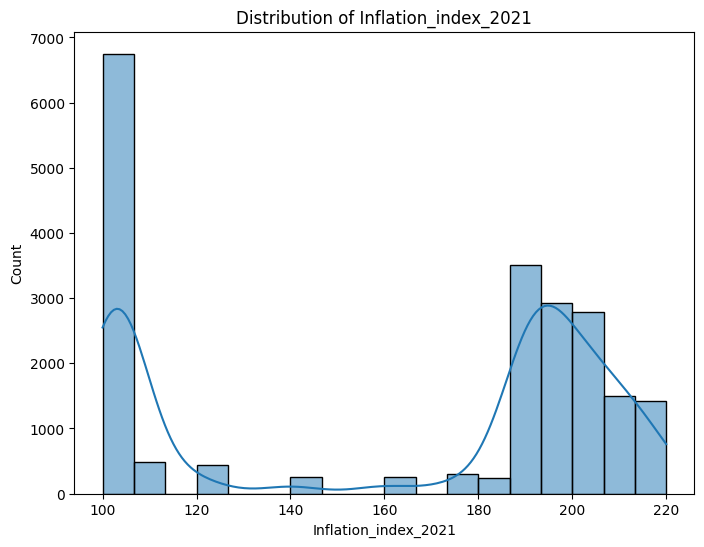

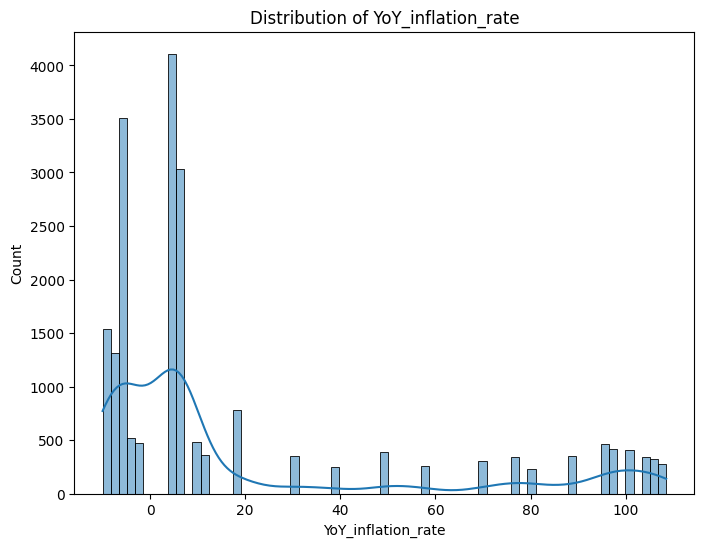

In [ ]:
#numeric_cols = final_merged_df.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_cols:
    plt.figure(figsize=(8, 6))
    sns.histplot(final_merged_df[col], kde=True)  # Use final_merged_df here as well
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)

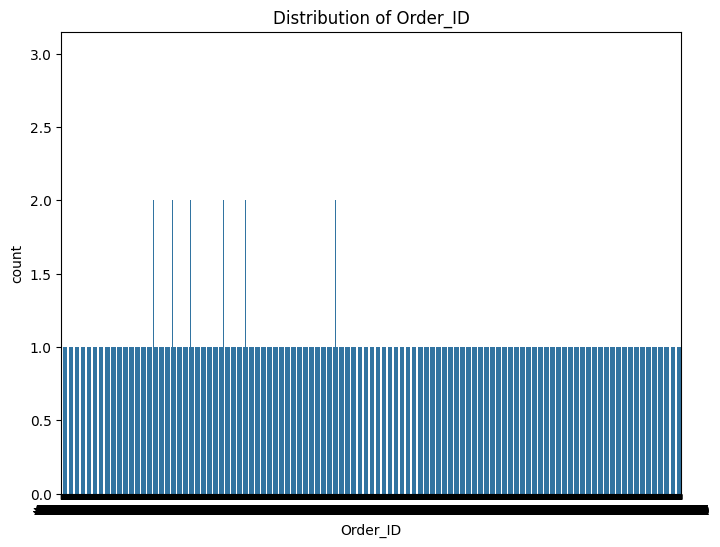

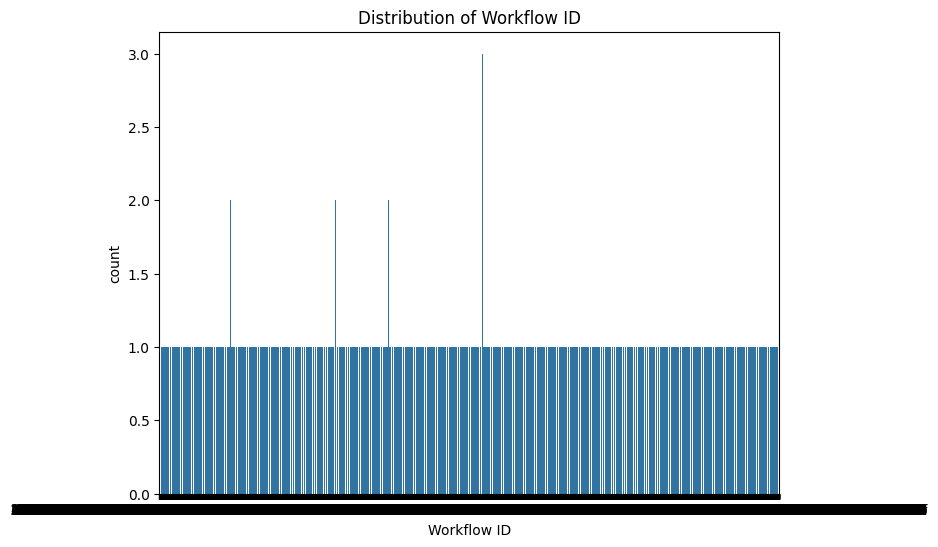

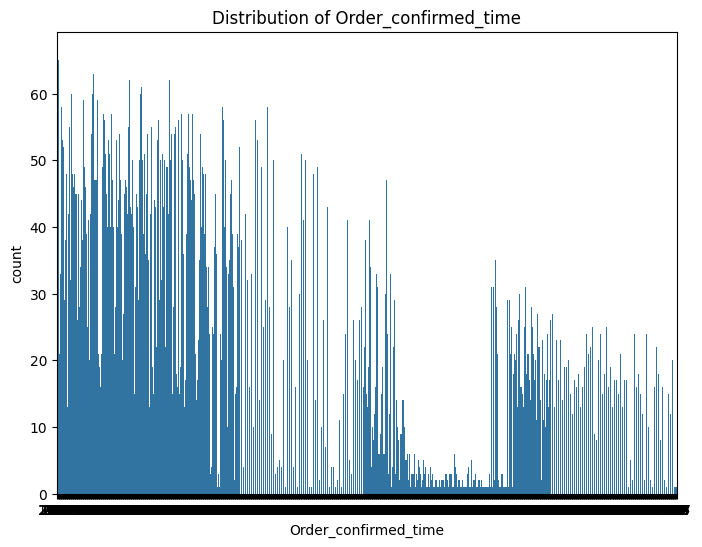

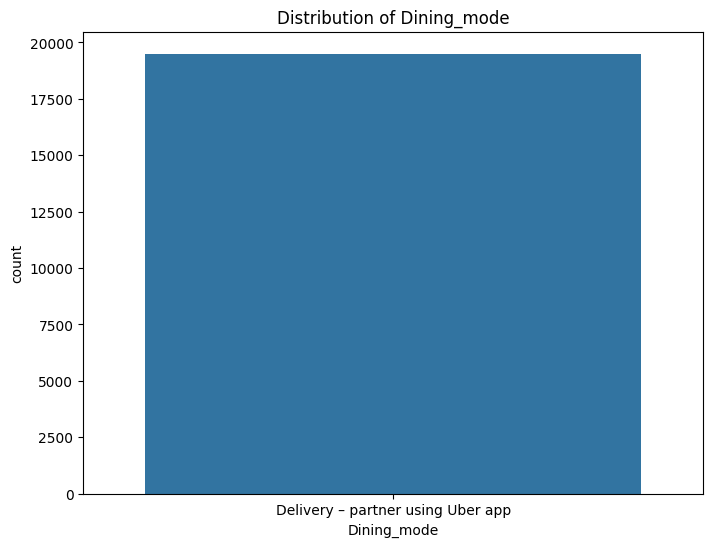

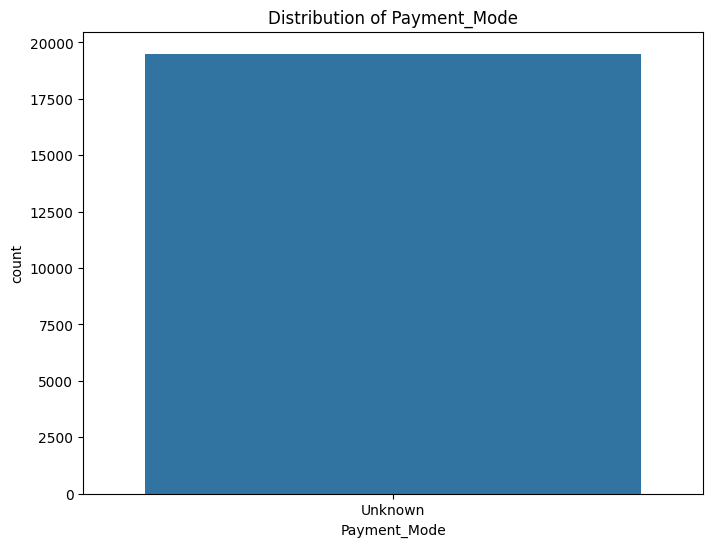

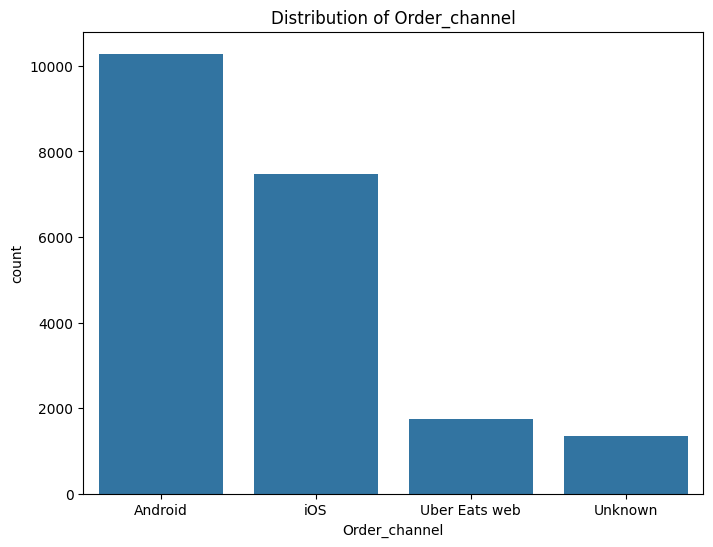

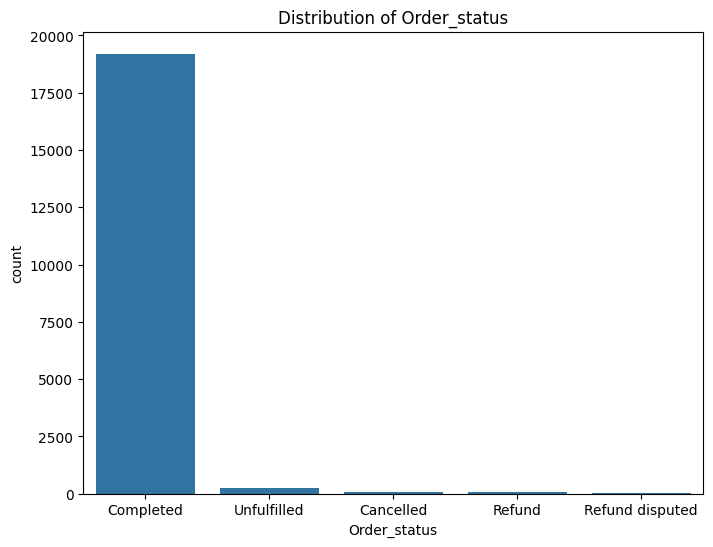

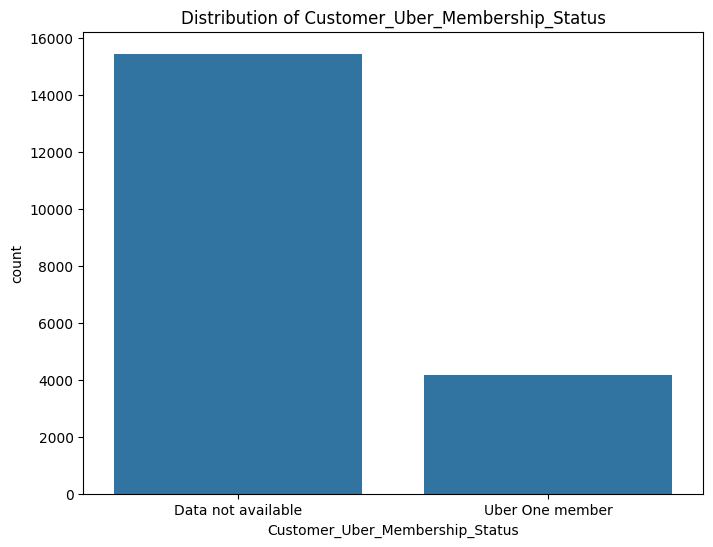

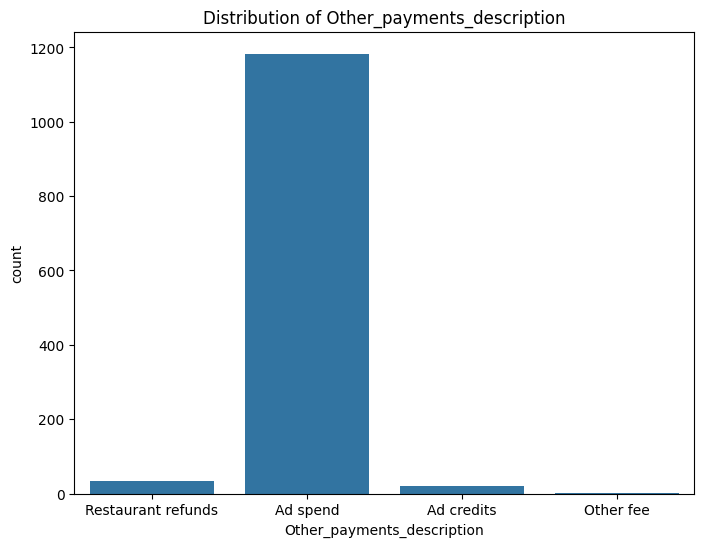

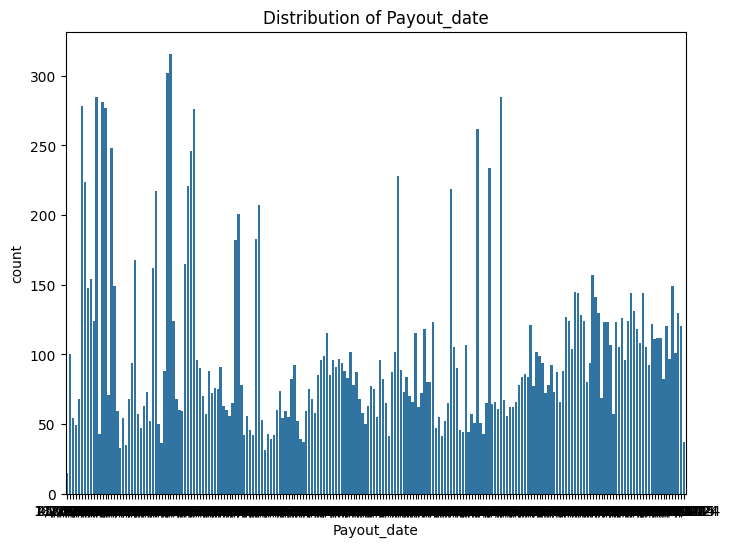

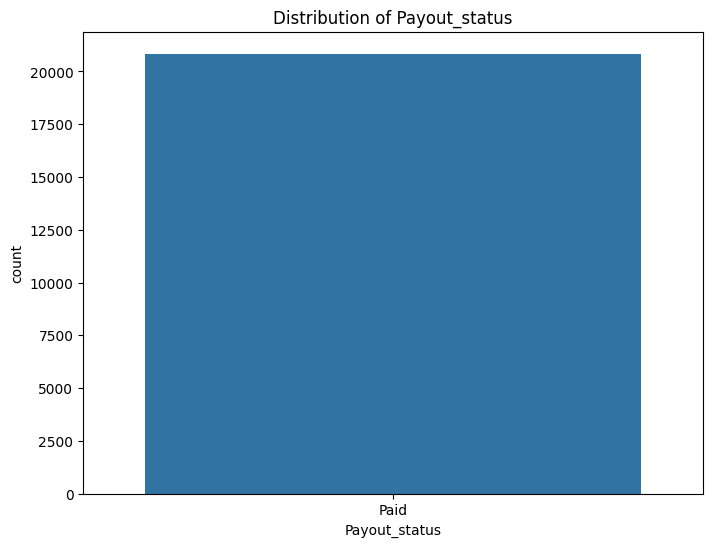

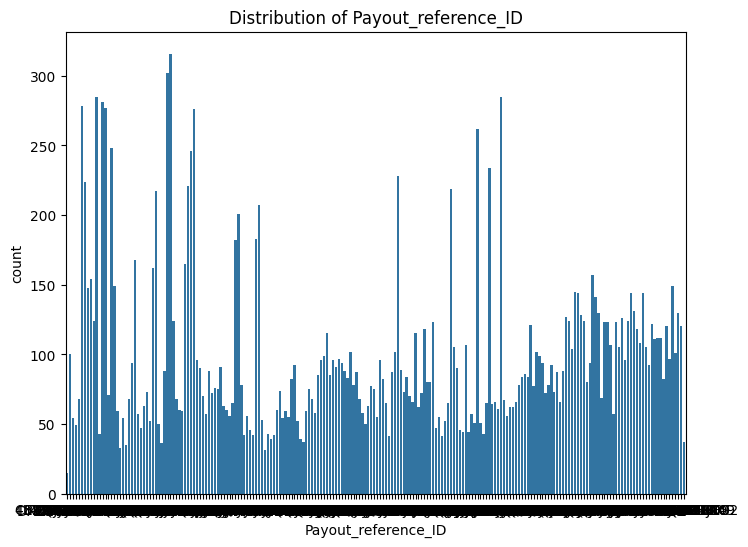

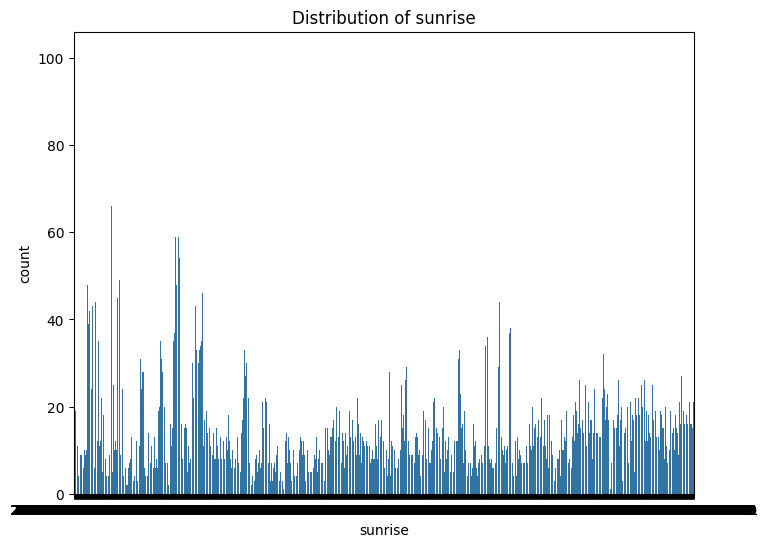

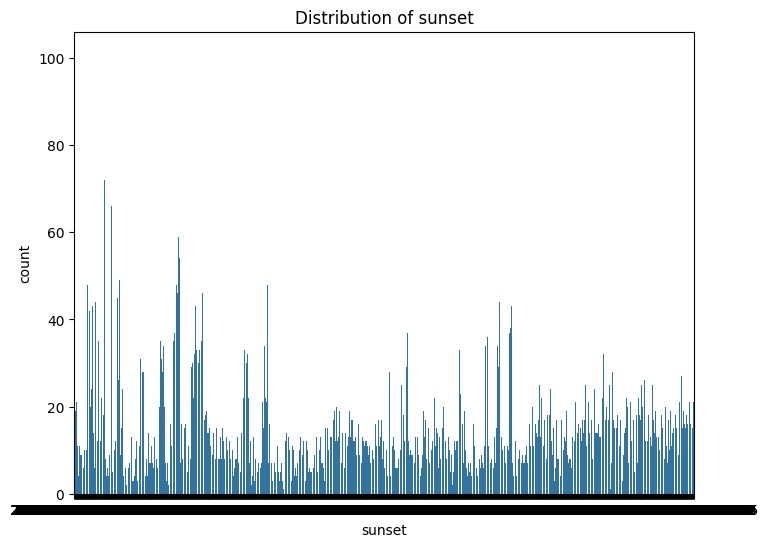

In [ ]:
# Exploration of Categorical Variables
categorical_cols = final_merged_df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    plt.figure(figsize=(8, 6))
    sns.countplot(data=final_merged_df, x=col)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)

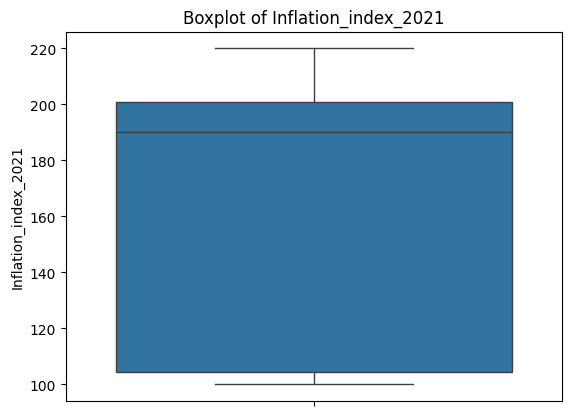

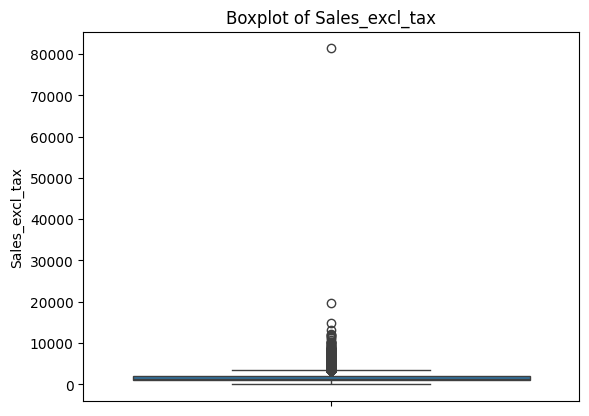

In [ ]:
# Boxplot for CPI
sns.boxplot(final_merged_df["Inflation_index_2021"])
plt.title("Boxplot of Inflation_index_2021")
plt.show()

# Boxplot for Sales
sns.boxplot(final_merged_df["Sales_excl_tax"])
plt.title("Boxplot of Sales_excl_tax")
plt.show()

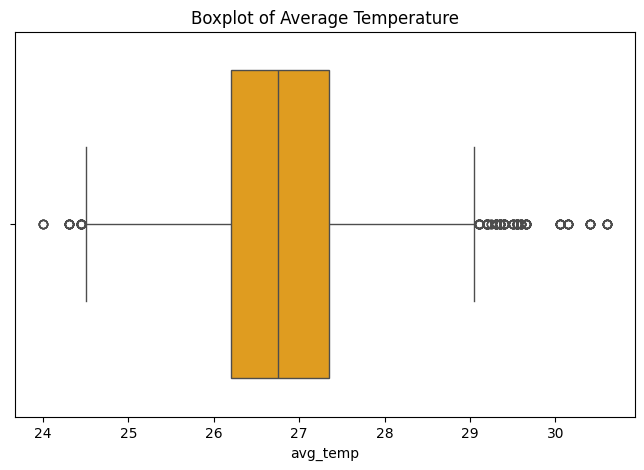

In [ ]:
# Calculate average temperature
final_merged_df['avg_temp'] = (final_merged_df['temperature_2m_max'] + final_merged_df['temperature_2m_min']) / 2

# Boxplot for average temperature
plt.figure(figsize=(8, 5))
sns.boxplot(x=final_merged_df['avg_temp'], color="orange")
plt.title("Boxplot of Average Temperature")
plt.show()

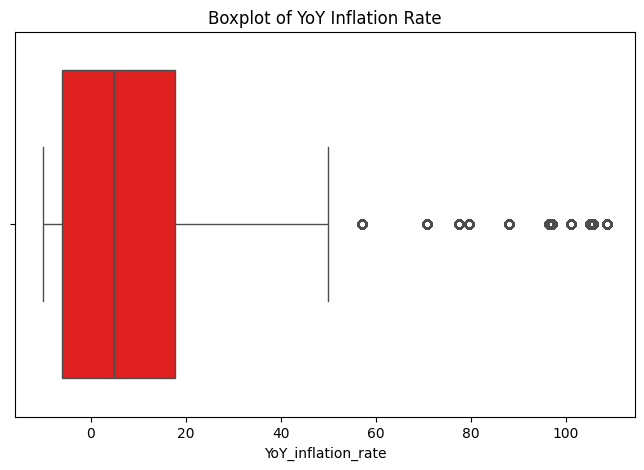

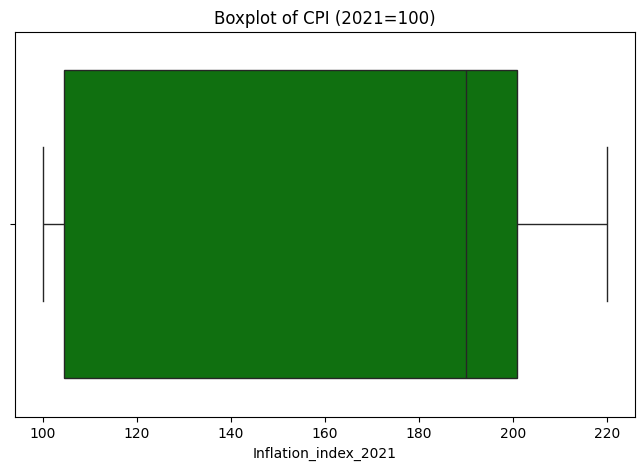

In [ ]:
# Create Boxplot for YoY Inflation Rate
plt.figure(figsize=(8, 5))
sns.boxplot(x=final_merged_df["YoY_inflation_rate"], color="red")  # Changed column name
plt.title("Boxplot of YoY Inflation Rate")
plt.show()

# Create Boxplot for Rebased CPI (2021=100)
plt.figure(figsize=(8, 5))
sns.boxplot(x=final_merged_df["Inflation_index_2021"], color="green")  # Changed column name
plt.title("Boxplot of CPI (2021=100)")
plt.show()

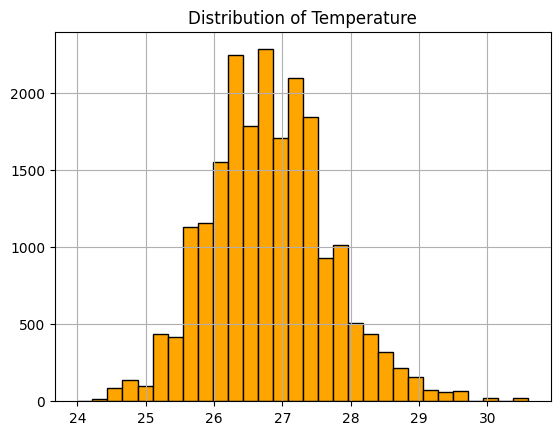

In [ ]:
# Histogram for Temperature
final_merged_df["avg_temp"].hist(bins=30, color="orange", edgecolor="black")
plt.title("Distribution of Temperature")
plt.show()

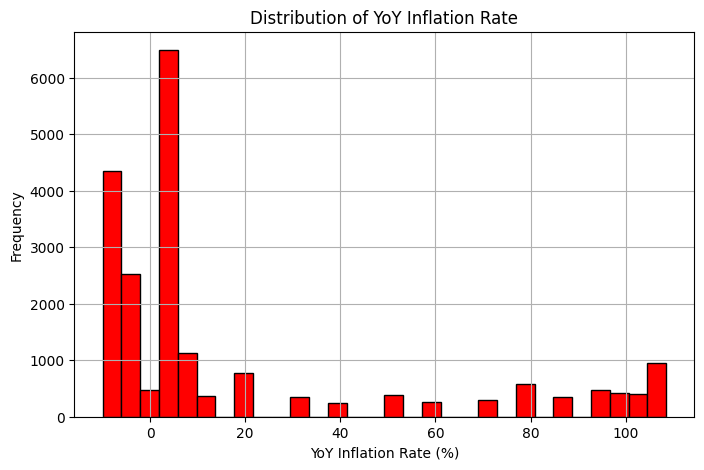

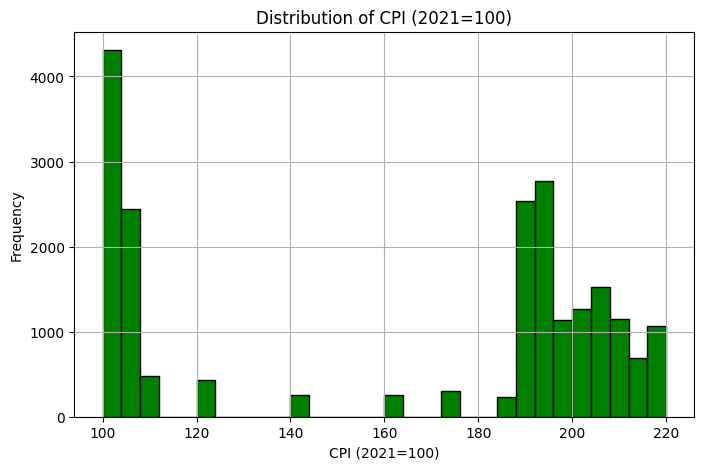

In [ ]:
# Create histogram for YoY Inflation Rate
plt.figure(figsize=(8, 5))
final_merged_df["YoY_inflation_rate"].hist(bins=30, color="red", edgecolor="black")
plt.title("Distribution of YoY Inflation Rate")
plt.xlabel("YoY Inflation Rate (%)")
plt.ylabel("Frequency")
plt.show()

# Create histogram for CPI (2021=100)
plt.figure(figsize=(8, 5))
final_merged_df["Inflation_index_2021"].hist(bins=30, color="green", edgecolor="black")
plt.title("Distribution of CPI (2021=100)")
plt.xlabel("CPI (2021=100)")
plt.ylabel("Frequency")
plt.show()

**Data Cleaning**

In [ ]:
# List of columns to drop
columns_to_drop = ['Order_ID', 'Workflow ID', 'Payment_Mode', 'Tax_on_sales', 'Refunds_excl_tax', 'Tax_on_refunds', 'Price_adjustments_excl_tax', 'Tax_on_price_adjustments', 'Promotions_on_items_excl_tax', 'Tax_on_promotion_on_items', 'Tax_on_delivery_fee', 'Promotions_on_delivery charge_excl_tax', 'Tax_on_promotions_on_delivery_charge', 'Promotions_on_delivery_charge_incl_tax','Bag_fee','Delivery_fee_excl_tax', 'Tax_on_delivery_fee.1', 'Service_fee', 'Tax_on_service_fee', 'Service _fee_discount', 'Discount_adjustments','Tax_adjustment','Other_payments_incl_tax','Payout_date','Payout_status','Invoice_link_U2R','Invoice_link_C2R','Invoice_link_R2E','Retailer_Loyalty_ID','Payout_reference_ID', 'temperature_2m_max', 'temperature_2m_min', 'apparent_temperature_max', 'apparent_temperature_min', 'sunrise', 'sunset', 'precipitation_sum', 'shortwave_radiation_sum']

# Drop the specified columns
final_merged_df = final_merged_df.drop(columns=columns_to_drop, errors='ignore')

# Display the updated DataFrame
print(final_merged_df.head())

  Order_date Order_confirmed_time                        Dining_mode  \
0 2021-01-01                19:19  Delivery – partner using Uber app   
1 2021-01-01                20:25  Delivery – partner using Uber app   
2 2021-01-01                20:28  Delivery – partner using Uber app   
3 2021-01-02                17:28  Delivery – partner using Uber app   
4 2021-01-02                18:47  Delivery – partner using Uber app   

  Order_channel Order_status Customer_Uber_Membership_Status  Sales_excl_tax  \
0       Android    Completed              Data not available            1000   
1       Android    Completed              Data not available            1550   
2           iOS    Completed              Data not available             600   
3       Android    Completed              Data not available            1000   
4           iOS    Completed              Data not available            3400   

   Promotions_on_items_incl_tax  Delivery_charge_excl_tax  \
0                        

In [ ]:
# Print the shape of the DataFrame
print("Shape of final_merged_df:", final_merged_df.shape)

Shape of final_merged_df: (20838, 21)


In [ ]:
# Convert 'Unfulfilled','Cancelled' and , 'Refund Disputed' to 'Completed' while keeping existing 'Completed'
final_merged_df['Order_status'] = final_merged_df['Order_status'].replace(['Unfulfilled', 'Cancelled', 'Refund disputed'], 'Completed')


In [ ]:
# Filter out rows with "Refund"
final_merged_df = final_merged_df[~final_merged_df['Order_status'].str.lower().isin(['refund'])]

In [ ]:
# Filter out rows with 'Order_channel' as "Unknown"
final_merged_df = final_merged_df[final_merged_df['Order_channel'] != 'Unknown']

In [ ]:
# Drop the specified columns
final_merged_df = final_merged_df.drop(columns=['Other_payments_description', 'Order_status', 'Dining_mode'])

In [ ]:
#Create a mapping dictionary for each weather code
weather_code_mapping = {
       0: "Clear sky",
       1: "Partly cloudy",
       2: "Cloudy",
       3: "Overcast",
       51: "Light drizzle",
       53: "Moderate drizzle",
       55: "Heavy drizzle",
       61: "Light rain",
       63: "Moderate rain",
       65: "Heavy rain",
}

In [ ]:
# Application of the mapping
final_merged_df['weather_description'] = final_merged_df['weather_code'].map(weather_code_mapping)

In [ ]:
# Drop weather code as mapping has been done
final_merged_df = final_merged_df.drop('weather_code', axis=1)

In [ ]:
# Convert 'Data not available' entries in 'Customer_Uber_Membership_Status' to 'Not Uber One member'
final_merged_df['Customer_Uber_Membership_Status'] = final_merged_df['Customer_Uber_Membership_Status'].replace('Data not available', 'Not Uber One member')

In [ ]:
# Check for null values in the entire DataFrame
missing_values = final_merged_df.isnull().sum()

# Print the results
print(missing_values)

Order_date                         0
Order_confirmed_time               0
Order_channel                      0
Customer_Uber_Membership_Status    0
Sales_excl_tax                     0
Promotions_on_items_incl_tax       0
Delivery_charge_excl_tax           0
Delivery_fee_incl_tax              0
Net_service_fee                    0
Profit_on_delivery                 0
Total_payout                       0
Year_Month                         0
rain_sum                           0
precipitation_hours                0
Inflation_index_2021               0
YoY_inflation_rate                 0
avg_temp                           0
weather_description                0
dtype: int64


**Feature Engineering**

In [ ]:
# Time-based Features
final_merged_df['order_dayofweek'] = final_merged_df['Order_date'].dt.dayofweek
final_merged_df['is_weekend'] = final_merged_df['order_dayofweek'].isin([5, 6]).astype(int)
final_merged_df['hour_of_day'] = pd.to_datetime(final_merged_df['Order_confirmed_time']).dt.hour

<ipython-input-54-85461b33b210>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  final_merged_df['hour_of_day'] = pd.to_datetime(final_merged_df['Order_confirmed_time']).dt.hour


In [ ]:
# Weather Features Calculate rain intensity, handling cases with zero rain sum
final_merged_df['rain_intensity'] = np.where(
    final_merged_df['rain_sum'] == 0,
    0,  # Set rain intensity to 0 if precipitation_sum is 0
    final_merged_df['rain_sum'] / (final_merged_df['precipitation_hours'].replace(0, 1))
)

In [ ]:
# Core Inflation Features
final_merged_df['month'] = final_merged_df['Order_date'].dt.month
final_merged_df['days_since_start'] = (final_merged_df['Order_date'] - final_merged_df['Order_date'].min()).dt.days
final_merged_df['is_month_end'] = final_merged_df['Order_date'].dt.is_month_end.astype(int)

In [ ]:
# Interaction Terms
final_merged_df['inflation_x_promotions'] = final_merged_df['YoY_inflation_rate'] * final_merged_df['Promotions_on_items_incl_tax']
final_merged_df['weekend_x_rain'] = final_merged_df['is_weekend'] * final_merged_df['rain_intensity']

**Post-Cleaning Exploratory Data Analysis (EDA)**

In [ ]:
final_merged_df.describe()

,Order_date,Sales_excl_tax,Promotions_on_items_incl_tax,Delivery_charge_excl_tax,Delivery_fee_incl_tax,Net_service_fee,Profit_on_delivery,Total_payout,rain_sum,precipitation_hours,...,avg_temp,order_dayofweek,is_weekend,hour_of_day,rain_intensity,month,days_since_start,is_month_end,inflation_x_promotions,weekend_x_rain
count,19502,19502.000000,19502.000000,19502.000000,19502.000000,19502.000000,19502.000000,19502.000000,19502.000000,19502.000000,...,19502.000000,19502.000000,19502.000000,19502.000000,19502.000000,19502.000000,19502.000000,19502.000000,19502.000000,19502.000000
mean,2022-12-09 10:05:28.581683968,1765.619424,-234.397908,140.895710,156.233305,-416.509156,13.701341,1085.557119,9.060896,11.898728,...,26.804523,3.144447,0.321916,16.606348,0.613033,6.466926,707.420470,0.041124,-2579.733328,0.221767
min,2021-01-01 00:00:00,250.000000,-6000.000000,0.000000,0.000000,-24412.500000,0.000000,0.000000,0.000000,0.000000,...,24.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-192720.000000,0.000000
25%,2021-10-08 00:00:00,1100.000000,-400.000000,94.000000,72.905000,-525.000000,0.000000,588.000000,1.700000,6.000000,...,26.200000,1.000000,0.000000,17.000000,0.188889,3.000000,280.000000,0.000000,-1892.000000,0.000000
50%,2022-12-10 00:00:00,1480.000000,0.000000,126.500000,133.130000,-340.500000,0.000000,910.000000,4.500000,12.000000,...,26.750000,3.000000,0.000000,19.000000,0.394737,7.000000,708.000000,0.000000,-0.000000,0.000000
75%,2024-02-05 00:00:00,2030.000000,0.000000,194.000000,210.350000,-210.000000,13.727500,1316.000000,13.075000,18.000000,...,27.350000,5.000000,1.000000,21.000000,0.880000,10.000000,1130.000000,0.000000,0.000000,0.180000
max,2024-12-31 00:00:00,81375.000000,0.000000,429.000000,1490.840000,0.000000,353.000000,56962.500000,108.500000,24.000000,...,30.600000,6.000000,1.000000,23.000000,8.346154,12.000000,1460.000000,1.000000,35353.500000,3.835714
std,NaN,1216.380929,394.344761,63.691235,113.523422,347.852396,29.946815,814.131541,11.116157,7.275015,...,0.876795,2.033867,0.467223,7.319168,0.632304,3.419000,456.129268,0.198582,10945.298905,0.522617


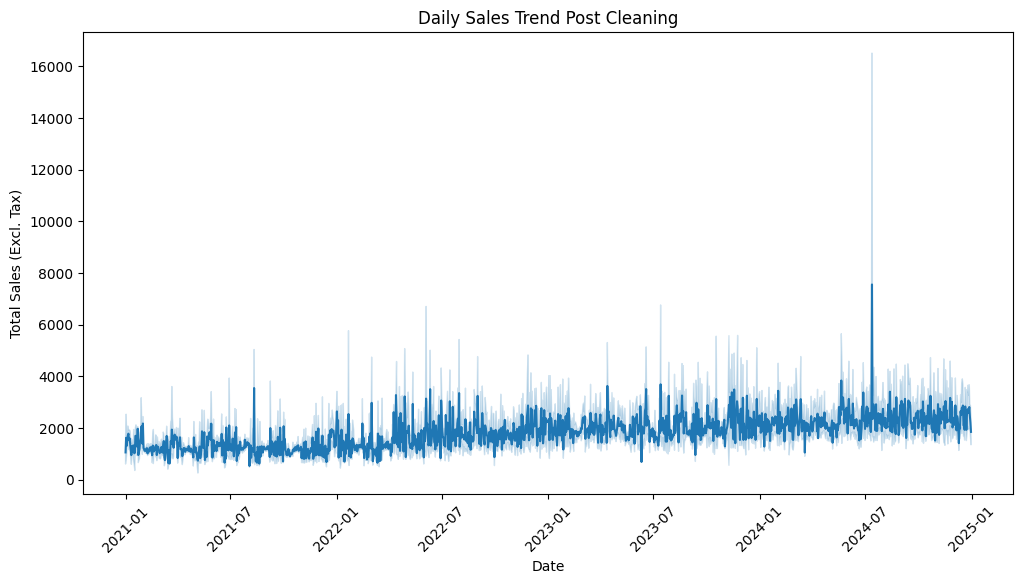

In [ ]:
# Visualizing Sales Trends Over Time
plt.figure(figsize=(12,6))
sns.lineplot(x=final_merged_df["Order_date"], y=final_merged_df["Sales_excl_tax"])
plt.title("Daily Sales Trend Post Cleaning")
plt.xlabel("Date")
plt.ylabel("Total Sales (Excl. Tax)")
plt.xticks(rotation=45)
plt.show()

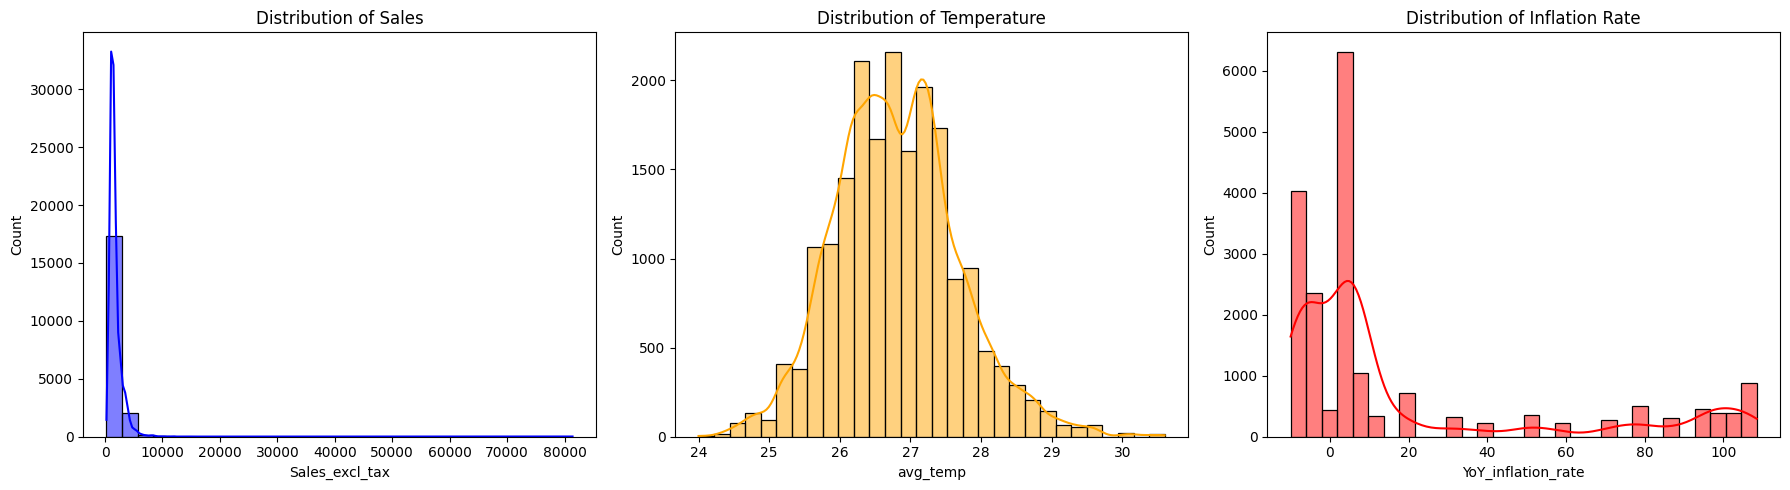

In [ ]:
# Distribution of Sales, Temperature, and Inflation Rate
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Using final_merged_df for sales, temperature, and inflation rate
sns.histplot(final_merged_df["Sales_excl_tax"], bins=30, kde=True, ax=axes[0], color="blue")
axes[0].set_title("Distribution of Sales")

sns.histplot(final_merged_df["avg_temp"], bins=30, kde=True, ax=axes[1], color="orange")
axes[1].set_title("Distribution of Temperature")

sns.histplot(final_merged_df["YoY_inflation_rate"], bins=30, kde=True, ax=axes[2], color="red")
axes[2].set_title("Distribution of Inflation Rate")

plt.tight_layout()
plt.show()

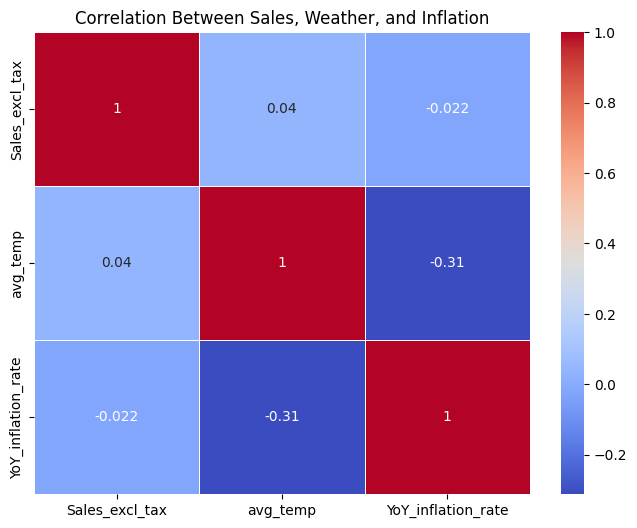

In [ ]:
# Correlation Heatmap (Sales, Weather, Inflation)
correlation_matrix = final_merged_df[["Sales_excl_tax", "avg_temp", "YoY_inflation_rate"]].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Between Sales, Weather, and Inflation")
plt.show()

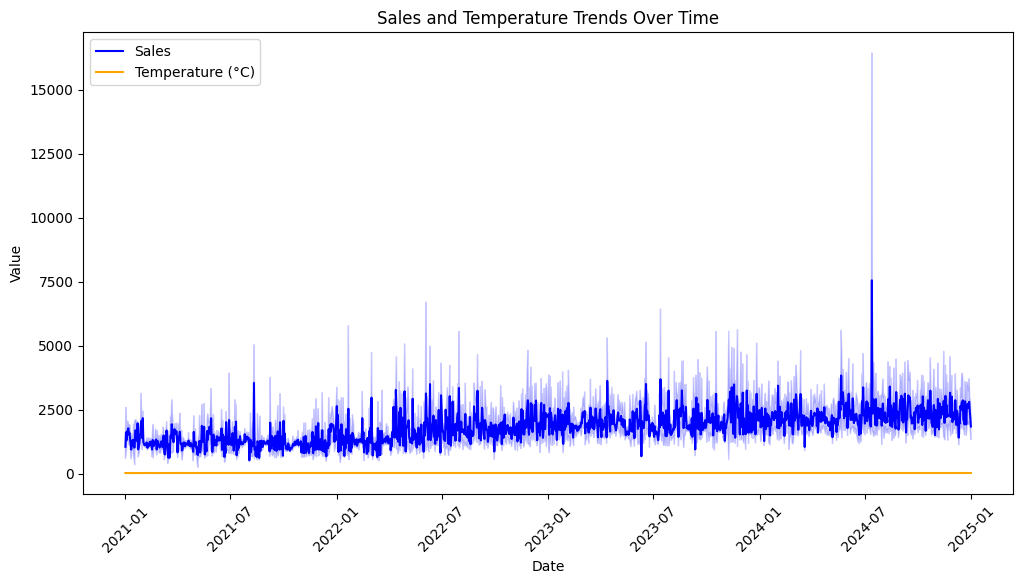

In [ ]:
# Plot Sales vs. Temperature Over Time
plt.figure(figsize=(12, 6))
sns.lineplot(x=final_merged_df["Order_date"], y=final_merged_df["Sales_excl_tax"], label="Sales", color="blue")
sns.lineplot(x=final_merged_df["Order_date"], y=final_merged_df["avg_temp"], label="Temperature (°C)", color="orange")

plt.title("Sales and Temperature Trends Over Time")
plt.xlabel("Date")
plt.ylabel("Value")
plt.xticks(rotation=45)
plt.legend()
plt.show()

**Encoding for Categorical Variables**

In [ ]:
# Define categorical columns
categorical_cols = ['Order_channel', 'weather_description', 'Customer_Uber_Membership_Status']

In [ ]:
# Convert 'Customer_Uber_Membership_Status' to string if it's boolean
final_merged_df['Customer_Uber_Membership_Status'] = final_merged_df['Customer_Uber_Membership_Status'].astype(str)

In [ ]:
# Initialize OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output=False, dtype=int)

In [ ]:
# Fit and transform on categorical columns
encoded_data = encoder.fit_transform(final_merged_df[categorical_cols])

# Get feature names for encoded columns
encoded_feature_names = encoder.get_feature_names_out(categorical_cols)

# Create new columns in the original DataFrame with encoded data
final_merged_df[encoded_feature_names] = encoded_data

# Drop original categorical columns
final_merged_df = final_merged_df.drop(columns=categorical_cols)

In [ ]:
#  Apply 3-day rolling average smoothing
final_merged_df['avg_temp_smoothed'] = final_merged_df['avg_temp'].rolling(window=3, min_periods=1).mean()
final_merged_df['YoY_inflation_rate_smoothed'] = final_merged_df['YoY_inflation_rate'].rolling(window=3, min_periods=1).mean()

In [ ]:
# Create a copy of the DataFrame before scaling
df_for_dashboard = final_merged_df.copy()

**Normalization**

In [ ]:
# Identify numerical features (excluding target and encoded features)
numerical_features = final_merged_df.select_dtypes(include=['number']).columns.tolist()
numerical_features.remove('Sales_excl_tax')  # Exclude target variable

In [ ]:
# Identify encoded feature prefixes
encoded_feature_prefix = ['Order_channel_', 'weather_description_', 'Customer_Uber_Membership_Status_']

In [ ]:
# Filter numerical features to exclude encoded ones
numerical_features_to_scale = [feature for feature in numerical_features if not any(feature.startswith(prefix) for prefix in encoded_feature_prefix)]

In [ ]:
# Initialize the StandardScaler
scaler = StandardScaler()

In [ ]:
# Fit and transform the scaler on the selected numerical features
final_merged_df[numerical_features_to_scale] = scaler.fit_transform(final_merged_df[numerical_features_to_scale])

In [ ]:
# To confirm scaling has applied properly
final_merged_df.head(100)

,Order_date,Order_confirmed_time,Sales_excl_tax,Promotions_on_items_incl_tax,Delivery_charge_excl_tax,Delivery_fee_incl_tax,Net_service_fee,Profit_on_delivery,Total_payout,Year_Month,...,weather_description_Heavy rain,weather_description_Light drizzle,weather_description_Light rain,weather_description_Moderate drizzle,weather_description_Moderate rain,weather_description_Overcast,weather_description_Partly cloudy,Customer_Uber_Membership_Status_Uber One member,avg_temp_smoothed,YoY_inflation_rate_smoothed
0,2021-01-01,19:19,1000,0.594414,-0.956133,-0.744388,0.334947,-0.181371,-0.463435,2021-01,...,0,0,0,0,1,0,0,0,-1.442793,-0.387466
1,2021-01-01,20:25,1550,0.594414,-0.799121,-0.699726,-0.139404,-0.016741,0.015530,2021-01,...,0,0,0,0,1,0,0,0,-1.442793,-0.387466
2,2021-01-01,20:28,600,0.594414,-1.270156,-0.943647,0.679930,-0.093880,-0.804150,2021-01,...,0,0,0,0,1,0,0,0,-1.442793,-0.387466
3,2021-01-02,17:28,1000,0.594414,-0.799121,0.329163,0.632782,-0.457534,-0.473593,2021-01,...,0,1,0,0,0,0,0,0,-1.193592,-0.387466
4,2021-01-02,18:47,3400,0.594414,-1.113144,-0.872823,-1.734949,-0.028429,1.605793,2021-01,...,0,1,0,0,0,0,0,0,-0.944391,-0.387466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2021-01-08,22:07,1500,0.594414,-1.427167,-1.074901,-0.096281,0.069747,-0.024281,2021-01,...,0,0,0,0,1,0,0,0,-2.075379,-0.387466
96,2021-01-08,22:37,550,0.594414,-0.799121,-0.986106,0.723053,1.068878,-0.804371,2021-01,...,0,0,0,0,1,0,0,0,-2.075379,-0.387466
97,2021-01-08,22:56,250,0.594414,-1.113144,-0.897312,0.981790,0.064404,-1.099270,2021-01,...,0,0,0,0,1,0,0,0,-2.075379,-0.387466
98,2021-01-09,18:27,850,0.594414,-1.270156,-1.017378,0.464316,0.185622,-0.578910,2021-01,...,0,0,0,0,1,0,0,0,-1.653655,-0.387466


**Model Training**

**Linear Regression Model**

In [ ]:
# Define the list of features used in the linear regression model
features = [
    'avg_temp_smoothed', 'rain_intensity', 'rain_sum', 'YoY_inflation_rate_smoothed',
    'Inflation_index_2021', 'Promotions_on_items_incl_tax', 'month', 'days_since_start',
    'order_dayofweek', 'is_weekend', 'is_month_end', 'hour_of_day',
    'inflation_x_promotions', 'weekend_x_rain'
] + [col for col in final_merged_df.columns if col.startswith(('Order_channel_', 'weather_description_', 'Customer_Uber_Membership_Status_'))]

X = final_merged_df[features]
y = final_merged_df['Sales_excl_tax']

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Identify numerical features to scale based on X_train columns
numerical_features_to_scale_current = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
cols_to_exclude_from_scaling = [
    'is_weekend', 'is_month_end', 'month', 'order_dayofweek', 'hour_of_day'
]
numerical_features_to_scale_current = [
    col for col in numerical_features_to_scale_current if col not in cols_to_exclude_from_scaling
]

In [ ]:
# Initialize a New StandardScaler and Fit only on X_train, then transform both X_train and X_test
scaler = StandardScaler()
X_train[numerical_features_to_scale_current] = scaler.fit_transform(X_train[numerical_features_to_scale_current])
# Transform X_test using the scaler fitted on X_train
X_test[numerical_features_to_scale_current] = scaler.transform(X_test[numerical_features_to_scale_current])


In [ ]:
# Train Linear Regression model on the SCALED training data
lr_model = LinearRegression().fit(X_train, y_train)


In [ ]:
# Predict on the SCALED test data
y_pred_lr = lr_model.predict(X_test)


In [ ]:
# Calculate metrics using the predictions and the original unscaled y_test
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

In [ ]:
# Display evaluation metrics
print("Linear Regression:")
print(f"RMSE: {rmse_lr:.2f}, MAE: {mae_lr:.2f}, R²: {r2_lr:.4f}")

Linear Regression:
RMSE: 832.85, MAE: 588.90, R²: 0.3084


**Random Forest**

In [ ]:
# Define features and target variable
features = [
    'avg_temp_smoothed', 'rain_intensity', 'rain_sum', 'YoY_inflation_rate_smoothed',
    'Inflation_index_2021', 'Promotions_on_items_incl_tax', 'month', 'days_since_start',
    'order_dayofweek', 'is_weekend', 'is_month_end', 'hour_of_day',
    'inflation_x_promotions', 'weekend_x_rain'
] + [col for col in final_merged_df.columns if col.startswith(('Order_channel_', 'weather_description_', 'Customer_Uber_Membership_Status_'))]

X = final_merged_df[features]
y = final_merged_df['Sales_excl_tax']

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Create and train the Random Forest Regression model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [ ]:
# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)


In [ ]:
# Evaluate the model's performance
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)


In [ ]:
# Display evaluation metrics
print("Random Forest Regression:")
print(f"RMSE: {rmse_rf:.2f}, MAE: {mae_rf:.2f}, R²: {r2_rf:.4f}")

Random Forest Regression:
RMSE: 896.40, MAE: 586.14, R²: 0.1988


**Gradient Boosting**

In [ ]:
# Define features and target variable
features = [
    'avg_temp_smoothed', 'rain_intensity', 'rain_sum', 'YoY_inflation_rate_smoothed',
    'Inflation_index_2021', 'Promotions_on_items_incl_tax', 'month', 'days_since_start',
    'order_dayofweek', 'is_weekend', 'is_month_end', 'hour_of_day',
    'inflation_x_promotions', 'weekend_x_rain'
] + [col for col in final_merged_df.columns if col.startswith(('Order_channel_', 'weather_description_', 'Customer_Uber_Membership_Status_'))]

X = final_merged_df[features]
y = final_merged_df['Sales_excl_tax']

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Create and train the Gradient Boosting Regression model
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)  # Adjust hyperparameters as needed
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

In [ ]:
# Make predictions on the test set
y_pred_gb = gb_model.predict(X_test)

In [ ]:
# Evaluate the model's performance
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
mae_gb = mean_absolute_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

In [ ]:
# Display evaluation metrics
print("Gradient Boosting Regression:")
print(f"RMSE: {rmse_gb:.2f}, MAE: {mae_gb:.2f}, R²: {r2_gb:.4f}")

Gradient Boosting Regression:
RMSE: 790.60, MAE: 530.83, R²: 0.3768


**Cat Boost**

In [ ]:
# Define features and target variable
features = [
    'avg_temp_smoothed', 'rain_intensity', 'rain_sum', 'YoY_inflation_rate_smoothed',
    'Inflation_index_2021', 'Promotions_on_items_incl_tax', 'month', 'days_since_start',
    'order_dayofweek', 'is_weekend', 'is_month_end', 'hour_of_day',
    'inflation_x_promotions', 'weekend_x_rain'
] + [col for col in final_merged_df.columns if col.startswith(('Order_channel_', 'weather_description_', 'Customer_Uber_Membership_Status_'))]

X = final_merged_df[features]
y = final_merged_df['Sales_excl_tax']

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Create and train the CatBoost Regression model
catboost_model = cb.CatBoostRegressor(
    iterations=100,
    learning_rate=0.1,
    depth=6,
    loss_function='RMSE',
    random_seed=42,
    verbose=False
)

catboost_model.fit(X_train, y_train)

In [ ]:
# Make predictions on the test set
y_pred_catboost = catboost_model.predict(X_test)


In [ ]:
# Evaluate the model's performance
rmse_catboost = np.sqrt(mean_squared_error(y_test, y_pred_catboost))
mae_catboost = mean_absolute_error(y_test, y_pred_catboost)
r2_catboost = r2_score(y_test, y_pred_catboost)

In [ ]:
# Display evaluation metrics
print("CatBoost Regression:")
print(f"RMSE: {rmse_catboost:.2f}, MAE: {mae_catboost:.2f}, R²: {r2_catboost:.4f}")

CatBoost Regression:
RMSE: 790.99, MAE: 530.89, R²: 0.3762


**Hyper Parameter Tuning and Retraining Each Model With New Parameters**

**Random Forest**

In [ ]:
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_grid_rf,
    n_iter=10,
    scoring='neg_root_mean_squared_error',
    cv=5,
    random_state=42,
    n_jobs=-1
)

rf_random_search.fit(X_train, y_train)

best_rf_model = rf_random_search.best_estimator_
print("Best Random Forest parameters:", rf_random_search.best_params_)

Best Random Forest parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 10}


In [ ]:
# Define features and target variable:
features = [
    'avg_temp_smoothed', 'rain_intensity', 'rain_sum', 'YoY_inflation_rate_smoothed',
    'Inflation_index_2021', 'Promotions_on_items_incl_tax', 'month', 'days_since_start',
    'order_dayofweek', 'is_weekend', 'is_month_end', 'hour_of_day',
    'inflation_x_promotions', 'weekend_x_rain'
] + [col for col in final_merged_df.columns if col.startswith(('Order_channel_', 'weather_description_', 'Customer_Uber_Membership_Status_'))]

X = final_merged_df[features]
y = final_merged_df['Sales_excl_tax']

In [ ]:
# Split data into training and testing sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Create and train the Random Forest model with the best parameters:
best_rf_params = {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 10}
rf_model = RandomForestRegressor(**best_rf_params, random_state=42)

rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=4, random_state=42)

In [ ]:
# Make predictions on the test set:
y_pred_rf = rf_model.predict(X_test)

In [ ]:
# Evaluate the model's performance:
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

In [ ]:
# Print the evaluation metrics:
print("Random Forest Regression (Retrained with Best Parameters):")
print(f"RMSE: {rmse_rf:.2f}, MAE: {mae_rf:.2f}, R²: {r2_rf:.4f}")

Random Forest Regression (Retrained with Best Parameters):
RMSE: 792.99, MAE: 528.95, R²: 0.3730


**Gradient Boosting**

In [ ]:
param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

gb_random_search = RandomizedSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_distributions=param_grid_gb,
    n_iter=10,
    scoring='neg_root_mean_squared_error',
    cv=5,
    random_state=42,
    n_jobs=-1
)

gb_random_search.fit(X_train, y_train)

best_gb_model = gb_random_search.best_estimator_
print("Best Gradient Boosting parameters:", gb_random_search.best_params_)


Best Gradient Boosting parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 3, 'learning_rate': 0.2}


In [ ]:
# Define your features and target variable:
features = [
    'avg_temp_smoothed', 'rain_intensity', 'rain_sum', 'YoY_inflation_rate_smoothed',
    'Inflation_index_2021', 'Promotions_on_items_incl_tax', 'month', 'days_since_start',
    'order_dayofweek', 'is_weekend', 'is_month_end', 'hour_of_day',
    'inflation_x_promotions', 'weekend_x_rain'
] + [col for col in final_merged_df.columns if col.startswith(('Order_channel_', 'weather_description_', 'Customer_Uber_Membership_Status_'))]

X = final_merged_df[features]
y = final_merged_df['Sales_excl_tax']

In [ ]:
# Split data into training and testing sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Identify numerical features to scale (if any)
numerical_features_to_scale = [
    'avg_temp_smoothed', 'rain_intensity', 'rain_sum', 'YoY_inflation_rate_smoothed',
    'Inflation_index_2021', 'Promotions_on_items_incl_tax', 'month', 'days_since_start',
    'order_dayofweek', 'hour_of_day', 'inflation_x_promotions', 'weekend_x_rain'
]

In [ ]:
# Scale numerical features in training and test data
scaler = StandardScaler()
X_train[numerical_features_to_scale] = scaler.fit_transform(X_train[numerical_features_to_scale])
X_test[numerical_features_to_scale] = scaler.transform(X_test[numerical_features_to_scale])

In [ ]:
# Train the Gradient Boosting model with the best parameters:
best_gb_params = {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 3, 'learning_rate': 0.2}
gb_model = GradientBoostingRegressor(**best_gb_params, random_state=42)  # Use ** to unpack the dictionary

gb_model.fit(X_train, y_train)


GradientBoostingRegressor(learning_rate=0.2, min_samples_leaf=2,
                          min_samples_split=5, n_estimators=200,
                          random_state=42)

In [ ]:
# Make predictions on the entire dataset (X)
X_scaled = X.copy()
X_scaled[numerical_features_to_scale] = scaler.transform(X[numerical_features_to_scale])

# Make predictions using the scaled data
y_pred_gb_scaled = gb_model.predict(X_scaled)


In [ ]:
# Add predicted values to DataFrame
final_merged_df['Predicted_Sales_GB'] = y_pred_gb_scaled
# Add predicted values to the copy
df_for_dashboard['Predicted_Sales_GB'] = y_pred_gb_scaled

In [ ]:
# Evaluate the model's performance:
rmse_gb = np.sqrt(mean_squared_error(y_test, gb_model.predict(X_test)))  # Evaluate on test set
mae_gb = mean_absolute_error(y_test, gb_model.predict(X_test))
r2_gb = r2_score(y_test, gb_model.predict(X_test))


In [ ]:
# Print the evaluation metrics:
print("Gradient Boosting Regression (Retrained with Best Parameters):")
print(f"RMSE: {rmse_gb:.2f}, MAE: {mae_gb:.2f}, R²: {r2_gb:.4f}")

Gradient Boosting Regression (Retrained with Best Parameters):
RMSE: 788.76, MAE: 527.28, R²: 0.3797


In [ ]:
# Save the unscaled copy with predictions
df_for_dashboard.to_csv('sales_predictions_for_dashboard.csv', index=False)

# Download the CSV file
from google.colab import files
files.download('sales_predictions_for_dashboard.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**CatBoost**

In [ ]:
param_grid_catboost = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5]
}

catboost_random_search = RandomizedSearchCV(
    estimator=cb.CatBoostRegressor(loss_function='RMSE', random_seed=42, verbose=False),
    param_distributions=param_grid_catboost,
    n_iter=10,
    scoring='neg_root_mean_squared_error',
    cv=5,
    random_state=42,
    n_jobs=-1
)

catboost_random_search.fit(X_train, y_train)

best_catboost_model = catboost_random_search.best_estimator_
print("Best CatBoost parameters:", catboost_random_search.best_params_)

Best CatBoost parameters: {'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 100, 'depth': 4}


In [ ]:
# Define your features and target variable:
features = [
    'avg_temp_smoothed', 'rain_intensity', 'rain_sum', 'YoY_inflation_rate_smoothed',
    'Inflation_index_2021', 'Promotions_on_items_incl_tax', 'month', 'days_since_start',
    'order_dayofweek', 'is_weekend', 'is_month_end', 'hour_of_day',
    'inflation_x_promotions', 'weekend_x_rain'
] + [col for col in final_merged_df.columns if col.startswith(('Order_channel_', 'weather_description_', 'Customer_Uber_Membership_Status_'))]

X = final_merged_df[features]
y = final_merged_df['Sales_excl_tax']


In [ ]:
# Split data into training and testing sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Create and train the CatBoost model with the best parameters:
best_catboost_params = {'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 100, 'depth': 4}
catboost_model = cb.CatBoostRegressor(**best_catboost_params, loss_function='RMSE', random_seed=42, verbose=False)

catboost_model.fit(X_train, y_train)

In [ ]:
# Make predictions on the test set:
y_pred_catboost = catboost_model.predict(X_test)

In [ ]:
# Evaluate the model's performance:
rmse_catboost = np.sqrt(mean_squared_error(y_test, y_pred_catboost))
mae_catboost = mean_absolute_error(y_test, y_pred_catboost)
r2_catboost = r2_score(y_test, y_pred_catboost)

In [ ]:
# Print the evaluation metrics:
print("CatBoost Regression (Retrained with Best Parameters):")
print(f"RMSE: {rmse_catboost:.2f}, MAE: {mae_catboost:.2f}, R²: {r2_catboost:.4f}")

CatBoost Regression (Retrained with Best Parameters):
RMSE: 794.04, MAE: 536.45, R²: 0.3714


**SHAP for Gradient Boosting**

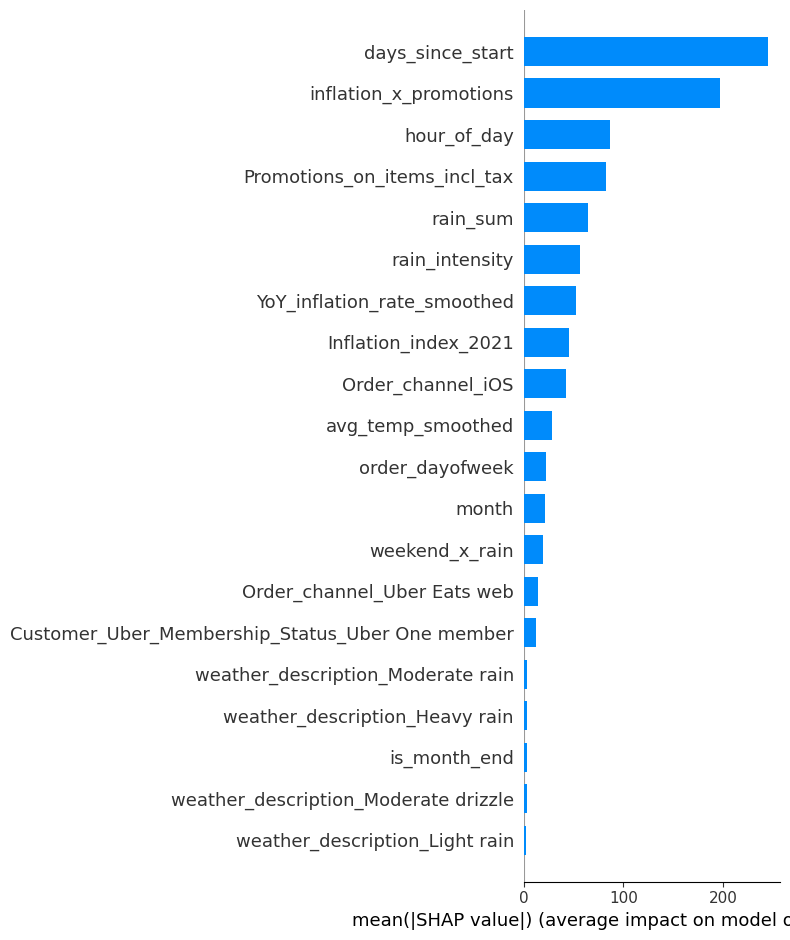

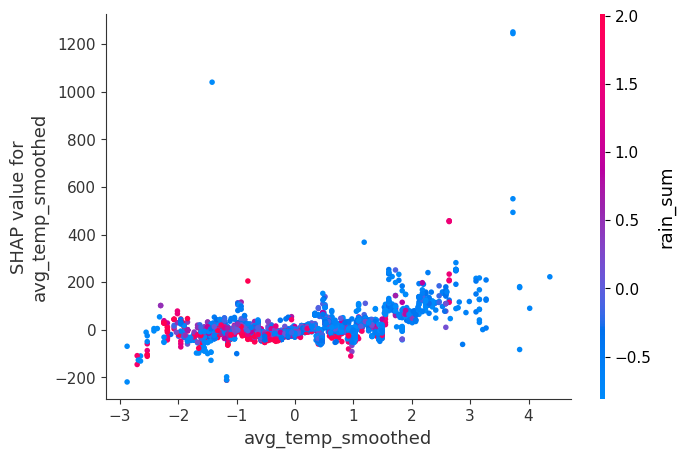

In [ ]:
!pip install shap
import shap

# Create the SHAP explainer
# For tree-based Gradient Boosting models:
explainer = shap.TreeExplainer(gb_model)

# Calculate SHAP values for the test data
shap_values = explainer.shap_values(X_test)

# Visualize global feature importance
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Visualize local feature contributions for a specific data point
# (the first data point in the test set)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

# Visualize SHAP dependence plot for a specific feature
# ('avg_temp_smoothed')
shap.dependence_plot("avg_temp_smoothed", shap_values, X_test)

**SHAP for Random Forest**

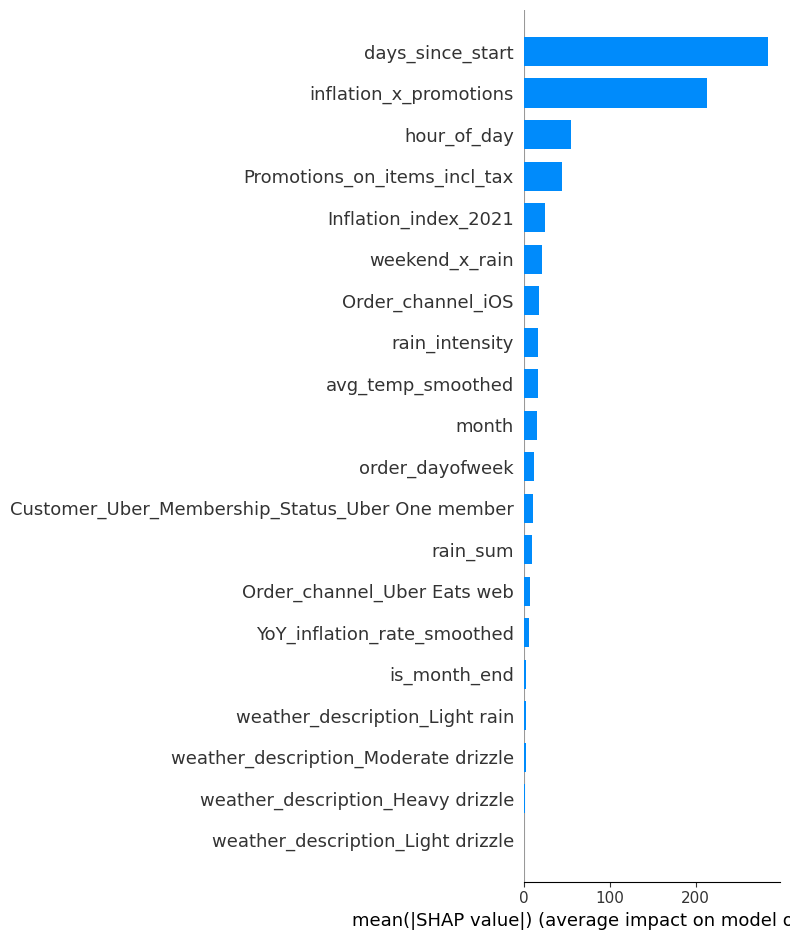

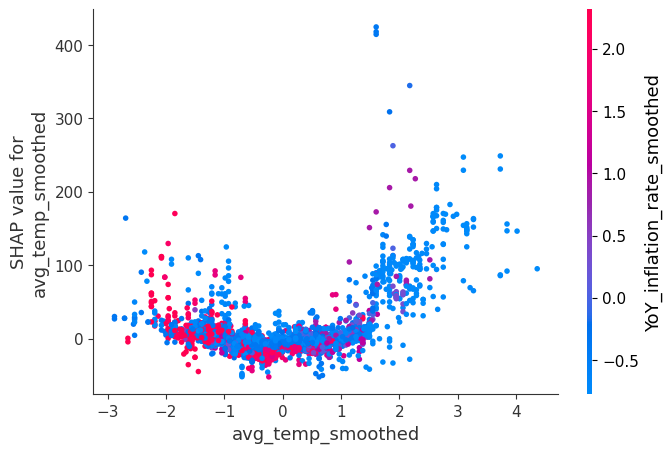

In [ ]:
# Create the SHAP explainer
explainer = shap.TreeExplainer(rf_model)

# Calculate SHAP values for the test data
shap_values = explainer.shap_values(X_test)

# Visualize global feature importance
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Visualize local feature contributions for a specific data point
# (the first data point in the test set)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

# Visualize SHAP dependence plot for a specific feature
# ('avg_temp_smoothed')
shap.dependence_plot("avg_temp_smoothed", shap_values, X_test)

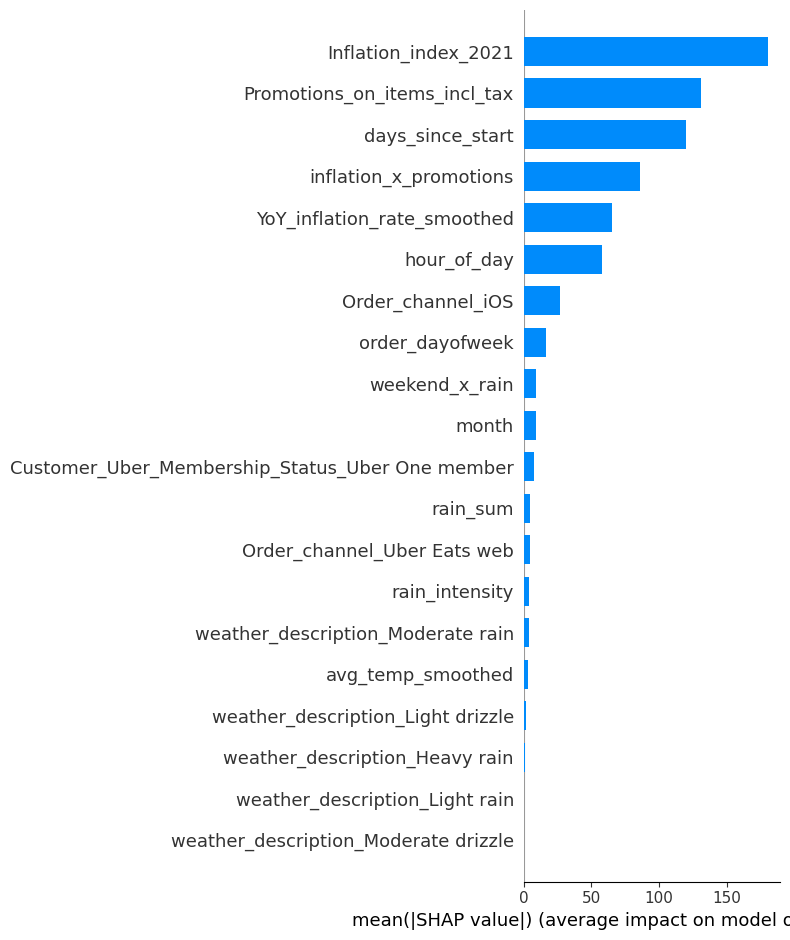

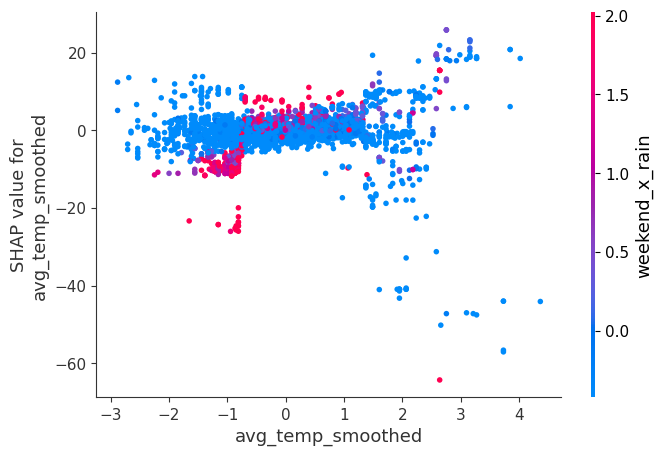

In [ ]:
==# Create the SHAP explainer
explainer = shap.TreeExplainer(catboost_model)

# Calculate SHAP values for the test data
shap_values = explainer.shap_values(X_test)

# Summary plot to show global feature importance
shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=X_test.columns)

# Dependence plot for a specific feature ('avg_temp_smoothed')
shap.dependence_plot("avg_temp_smoothed", shap_values, X_test, feature_names=X_test.columns)

# Force plot to show local feature contributions for a specific data point
# (the first data point in the test set)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:], feature_names=X_test.columns)